<a href="https://colab.research.google.com/github/NoraHK3/DataSciProject/blob/main/EDA_Attempt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SECONDARY DATA

In [ ]:
# First, let's see the overall structure
!gsutil ls gs://nutrition5k_dataset/

# If that works, explore the nutrition5k_dataset directory
!gsutil ls gs://nutrition5k_dataset/nutrition5k_dataset/

# Let's recursively list everything to understand the structure
!gsutil ls -r gs://nutrition5k_dataset/nutrition5k_dataset/ | head -50

#DOWNLOADING METADATA
# No authentication needed for public buckets
!gsutil ls gs://nutrition5k_dataset/

# Check if bucket is publicly accessible
!gsutil ls -L gs://nutrition5k_dataset/

# Copy specific files without auth
!gsutil -m cp -r "gs://nutrition5k_dataset/nutrition5k_dataset/metadata/" ./

gs://nutrition5k_dataset/nutrition5k_dataset.tar.gz
gs://nutrition5k_dataset/nutrition5k_dataset/
gs://nutrition5k_dataset/nutrition5k_dataset/README
gs://nutrition5k_dataset/nutrition5k_dataset/dish_ids/
gs://nutrition5k_dataset/nutrition5k_dataset/imagery/
gs://nutrition5k_dataset/nutrition5k_dataset/metadata/
gs://nutrition5k_dataset/nutrition5k_dataset/scripts/
gs://nutrition5k_dataset/nutrition5k_dataset/:
gs://nutrition5k_dataset/nutrition5k_dataset/README

gs://nutrition5k_dataset/nutrition5k_dataset/dish_ids/:
gs://nutrition5k_dataset/nutrition5k_dataset/dish_ids/README
gs://nutrition5k_dataset/nutrition5k_dataset/dish_ids/dish_ids_all.txt
gs://nutrition5k_dataset/nutrition5k_dataset/dish_ids/dish_ids_cafe1.txt
gs://nutrition5k_dataset/nutrition5k_dataset/dish_ids/dish_ids_cafe2.txt

gs://nutrition5k_dataset/nutrition5k_dataset/dish_ids/splits/:
gs://nutrition5k_dataset/nutrition5k_dataset/dish_ids/splits/depth_test_ids.txt
gs://nutrition5k_dataset/nutrition5k_dataset/dish_ids/

In [ ]:
# ONLY WORKING METHOD WITH IMAGERY
# Method: Download and rename files to avoid overwriting
import os
import subprocess

os.makedirs('./rgb_samples_fixed', exist_ok=True)

# First, get the list of dish directories
result = subprocess.run([
    'gsutil', 'ls', 'gs://nutrition5k_dataset/nutrition5k_dataset/imagery/realsense_overhead/'
], capture_output=True, text=True)

dish_dirs = result.stdout.strip().split('\n')
print(f"Found {len(dish_dirs)} dish directories")

# Download first 50 images with unique names
for i, dish_dir in enumerate(dish_dirs[:200]):
    if dish_dir:
        rgb_path = dish_dir + 'rgb.png'
        # Extract dish ID from path
        dish_id = os.path.basename(dish_dir.rstrip('/'))
        local_filename = f'./rgb_samples_fixed/{dish_id}_rgb.png'

        print(f"Downloading {rgb_path} -> {local_filename}")
        !gsutil cp "{rgb_path}" "{local_filename}"

        # Verify download
        if os.path.exists(local_filename):
            print(f"✓ Success: {local_filename}")
        else:
            print(f"✗ Failed: {local_filename}")

print("\nFinal contents:")
!ls -la ./rgb_samples_fixed/

Found 3490 dish directories
Copying gs://nutrition5k_dataset/nutrition5k_dataset/imagery/realsense_overhead/dish_1556572657/rgb.png...
/ [1 files][402.5 KiB/402.5 KiB]                                                
Operation completed over 1 objects/402.5 KiB.                                    
✓ Success: ./rgb_samples_fixed/dish_1556572657_rgb.png
Copying gs://nutrition5k_dataset/nutrition5k_dataset/imagery/realsense_overhead/dish_1556573514/rgb.png...
/ [1 files][422.8 KiB/422.8 KiB]                                                
Operation completed over 1 objects/422.8 KiB.                                    
✓ Success: ./rgb_samples_fixed/dish_1556573514_rgb.png
Copying gs://nutrition5k_dataset/nutrition5k_dataset/imagery/realsense_overhead/dish_1556575014/rgb.png...
/ [1 files][400.2 KiB/400.2 KiB]                                                
Operation completed over 1 objects/400.2 KiB.                                    
✓ Success: ./rgb_samples_fixed/dish_1556575014_rgb.p

Starting Nutrition5k Metadata Review Analysis...
🔍 NUTRITION5K METADATA REVIEW
✅ Successfully loaded nutritional metadata
Dataset Shape: (555, 6)
Columns: ['ingr', 'id', 'cal/g', 'fat(g)', 'carb(g)', 'protein(g)']

First 5 rows:
             ingr  id  cal/g  fat(g)  carb(g)  protein(g)
0  cottage cheese   1  0.980   0.043    0.034       0.110
1    strawberries   2  0.330   0.003    0.080       0.007
2    garden salad   3  0.646   0.034    0.032       0.061
3           bacon   4  5.410   0.420    0.014       0.370
4        potatoes   5  0.770   0.001    0.170       0.020

METADATA STRUCTURE ANALYSIS
Data Types:
ingr           object
id              int64
cal/g         float64
fat(g)        float64
carb(g)       float64
protein(g)    float64
dtype: object

Missing Values:
  ingr: 0 (0.0%)
  id: 0 (0.0%)
  cal/g: 0 (0.0%)
  fat(g): 0 (0.0%)
  carb(g): 0 (0.0%)
  protein(g): 0 (0.0%)

Basic Statistics:
               id       cal/g      fat(g)     carb(g)  protein(g)
count  555.000000  555

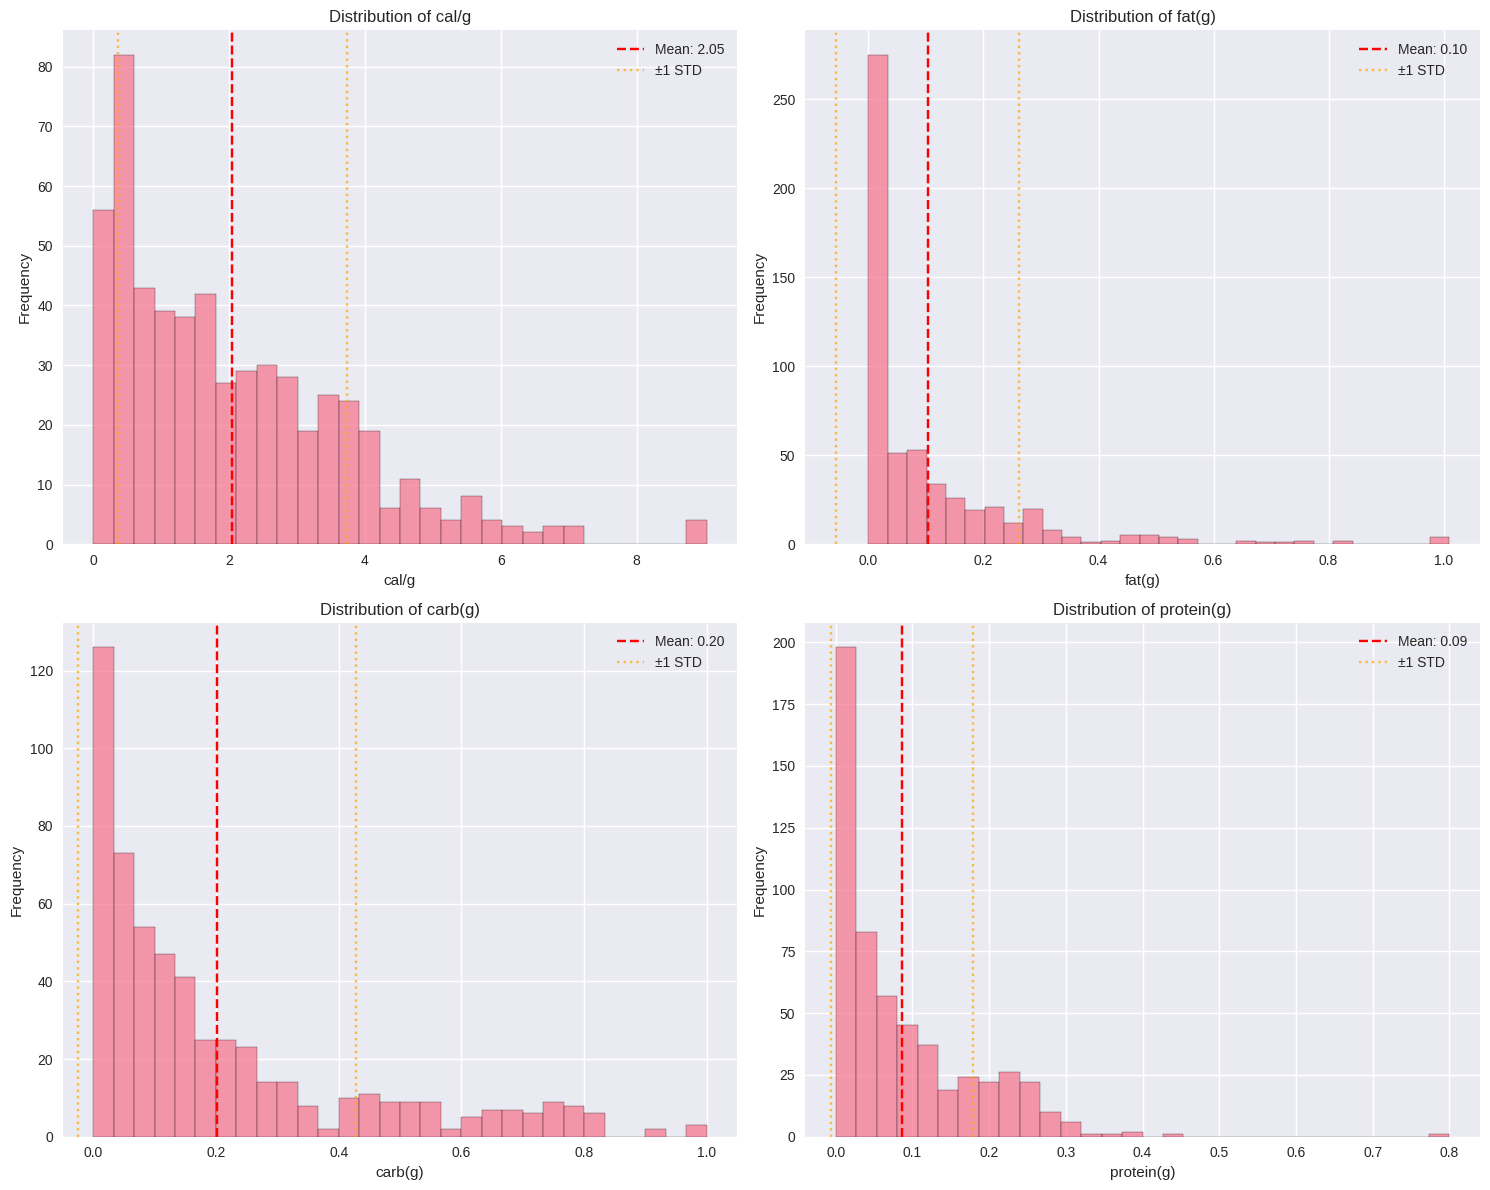


Nutritional Components Summary:

cal/g:
  Mean: 2.05 ± 1.68
  Range: 0.00 - 9.03
  Median: 1.64
  Skewness: 1.158

fat(g):
  Mean: 0.10 ± 0.16
  Range: 0.00 - 1.01
  Median: 0.04
  Skewness: 2.754

carb(g):
  Mean: 0.20 ± 0.23
  Range: 0.00 - 1.00
  Median: 0.11
  Skewness: 1.442

protein(g):
  Mean: 0.09 ± 0.09
  Range: 0.00 - 0.80
  Median: 0.05
  Skewness: 1.769

NUTRIENT CORRELATION ANALYSIS


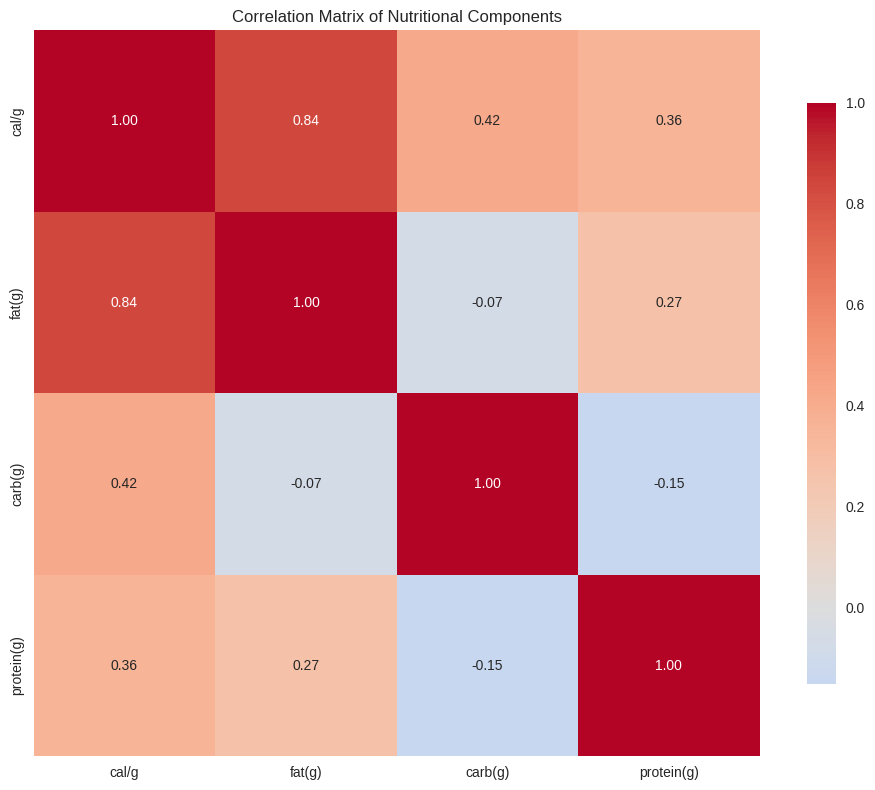

Key Correlation Insights:
  cal/g vs fat(g): 0.843 (strong positive correlation)
  cal/g vs carb(g): 0.419 (moderate positive correlation)
  cal/g vs protein(g): 0.361 (moderate positive correlation)
  fat(g) vs carb(g): -0.073 (weak negative correlation)
  fat(g) vs protein(g): 0.269 (weak positive correlation)
  carb(g) vs protein(g): -0.151 (weak negative correlation)

CALORIC DENSITY ANALYSIS


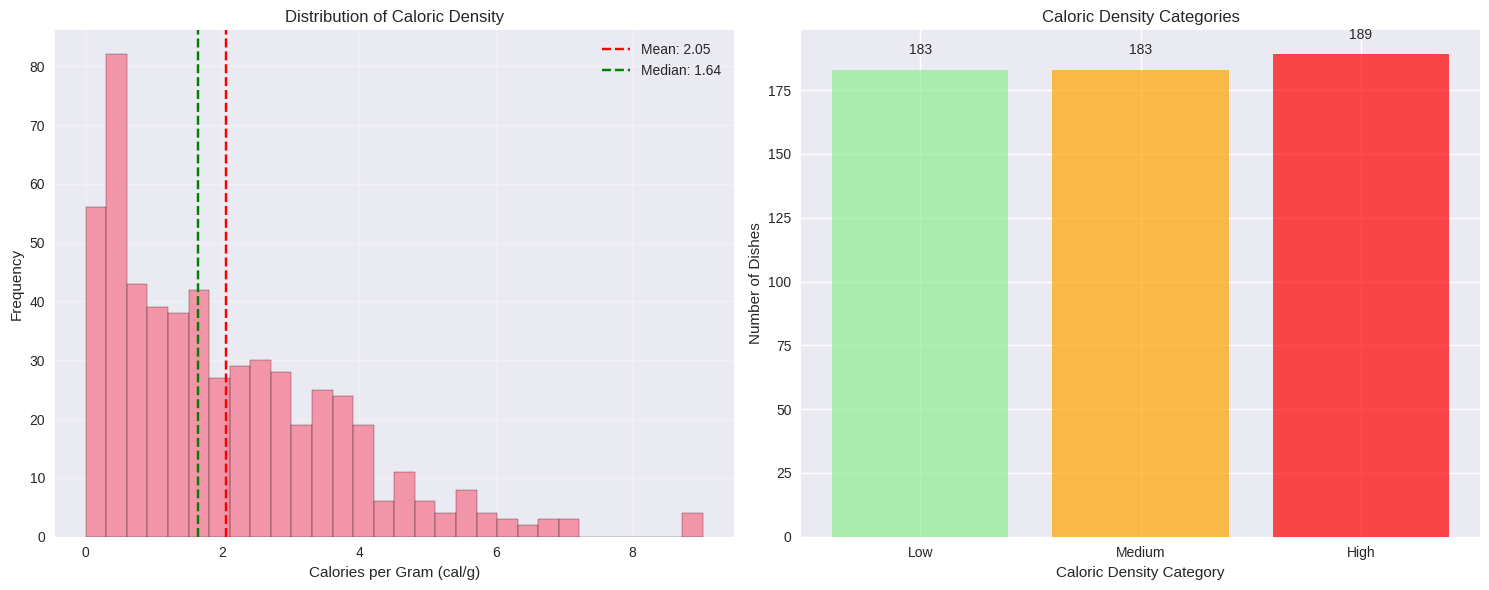

Caloric Density Statistics:
  Mean: 2.051 cal/g
  Median: 1.637 cal/g
  Standard Deviation: 1.683 cal/g
  Range: 0.000 - 9.033 cal/g

Caloric Density Categories:
  Low (<0.907 cal/g): 183 dishes
  Medium: 183 dishes
  High (≥2.554 cal/g): 189 dishes

MACRONUTRIENT BALANCE ANALYSIS


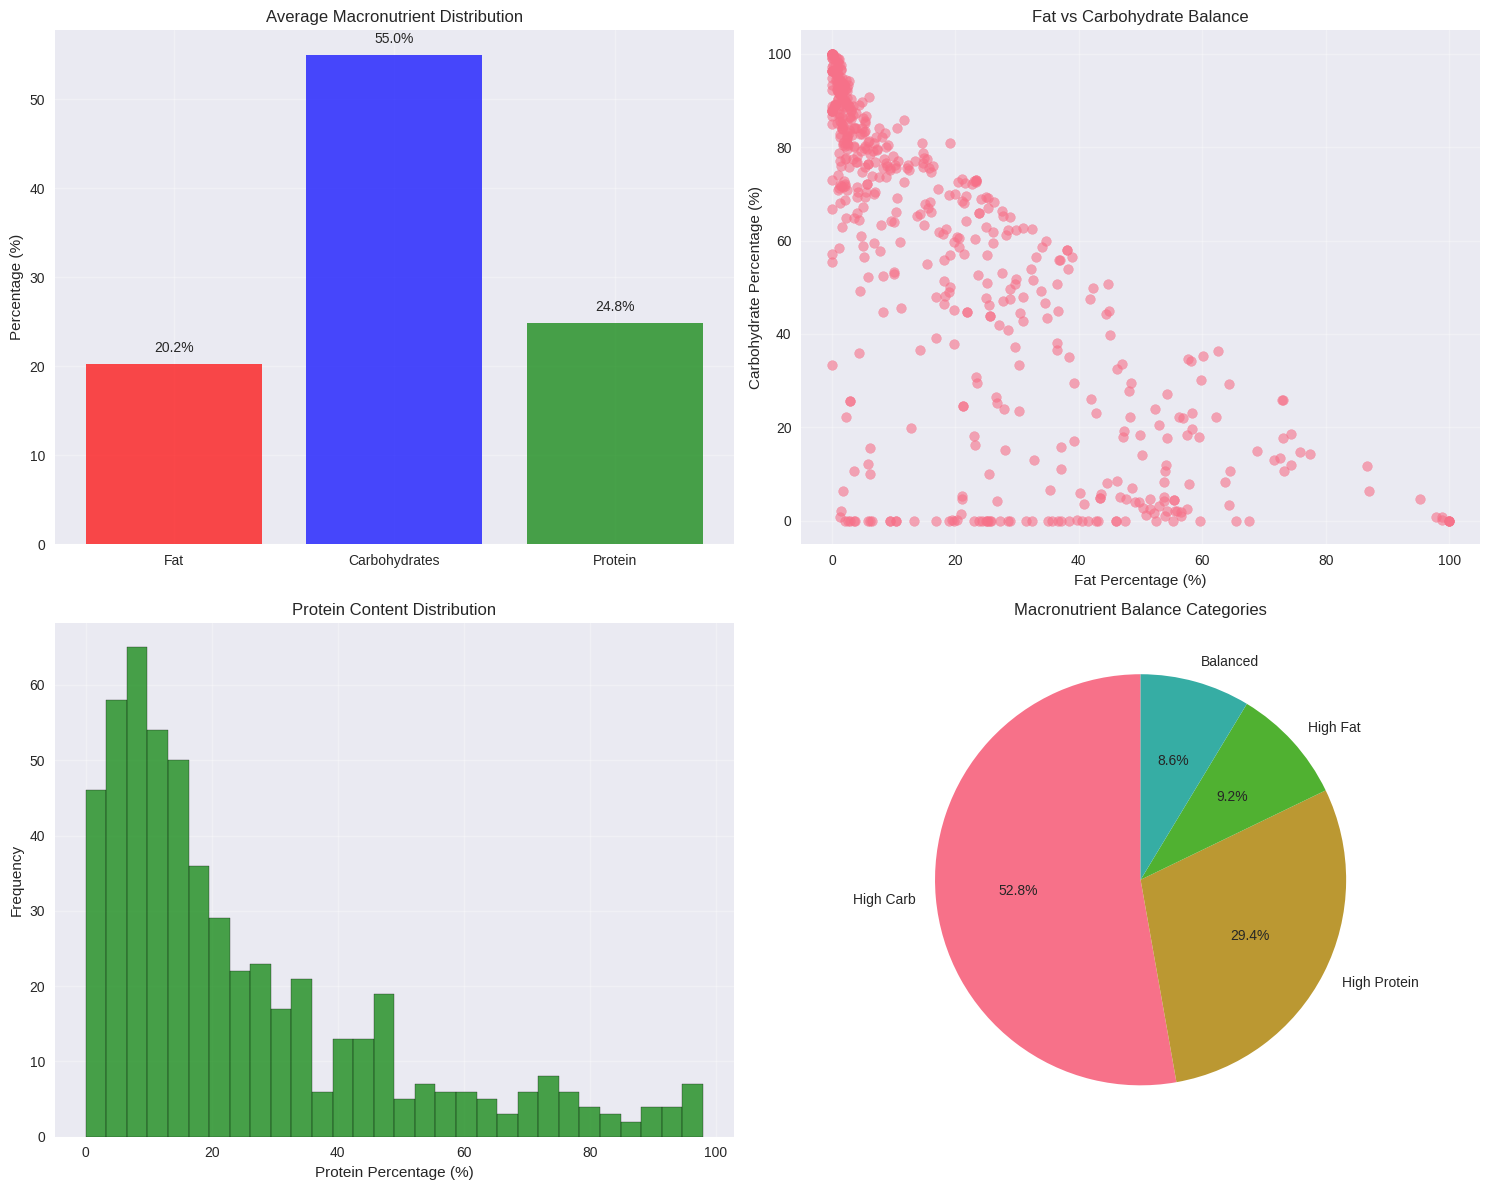

Macronutrient Balance Summary:
  Average Fat: 20.2%
  Average Carbohydrates: 55.0%
  Average Protein: 24.8%

Balance Categories:
  High Carb: 293 dishes (52.8%)
  High Protein: 163 dishes (29.4%)
  High Fat: 51 dishes (9.2%)
  Balanced: 48 dishes (8.6%)

NUTRITION5K METADATA REVIEW REPORT

📊 DATASET CONTEXT:
   - Source: Nutrition5k Research Dataset
   - Collection Method: Laboratory analysis of dish nutritional content
   - Purpose: Computer vision nutrition estimation research
   - Scale: 555 dishes with detailed nutritional analysis

🔬 DATA COLLECTION METHODOLOGY:
   - Standardized laboratory nutritional analysis
   - Macronutrient breakdown (fat, carbs, protein)
   - Caloric density calculation
   - Per-gram measurements for consistency

📈 KEY METADATA INSIGHTS:
   - Caloric density varies 9.03 cal/g across dishes
   - Data completeness: 100.0%

🎯 RESEARCH IMPLICATIONS:
   - Enables visual-nutrition correlation studies
   - Supports computer vision model training for nutrition esti

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# --- Load and Explore Nutrition5k Metadata ---

def load_nutrition5k_metadata():
    """Load and analyze Nutrition5k nutritional metadata"""
    print("🔍 NUTRITION5K METADATA REVIEW")
    print("="*60)

    # Load the nutritional metadata (adjust path as needed)
    # Assuming you have this from the dish_ids folder
    try:
        nutrition_df = pd.read_csv('./metadata/ingredients_metadata.csv')  # Adjust path as needed
        print("✅ Successfully loaded nutritional metadata")
    except FileNotFoundError:
        print("❌ Nutritional metadata file not found")
        print("Trying to load from dish_ids directory...")
        # Alternative loading method
        try:
            nutrition_df = pd.read_csv('./nutrition5k_dataset/dish_ids/nutritional_info.csv')
        except:
            print("❌ Could not load nutritional metadata")
            return None

    # Display basic information
    print(f"Dataset Shape: {nutrition_df.shape}")
    print(f"Columns: {nutrition_df.columns.tolist()}")
    print("\nFirst 5 rows:")
    print(nutrition_df.head())

    return nutrition_df

def analyze_metadata_structure(nutrition_df):
    """Analyze the structure and quality of metadata"""
    print("\n" + "="*50)
    print("METADATA STRUCTURE ANALYSIS")
    print("="*50)

    # Data types and missing values
    print("Data Types:")
    print(nutrition_df.dtypes)

    print("\nMissing Values:")
    missing_data = nutrition_df.isnull().sum()
    for col, missing in missing_data.items():
        print(f"  {col}: {missing} ({missing/len(nutrition_df)*100:.1f}%)")

    # Basic statistics for numerical columns
    print("\nBasic Statistics:")
    print(nutrition_df.describe())

    return missing_data

def analyze_nutritional_distributions(nutrition_df):
    """Analyze distributions of nutritional components"""
    print("\n" + "="*50)
    print("NUTRITIONAL COMPONENTS DISTRIBUTION")
    print("="*50)

    # Select nutritional columns (adjust based on actual column names)
    nutritional_cols = ['cal/g', 'fat(g)', 'carb(g)', 'protein(g)']  # Adjust as needed

    # Check which columns actually exist
    available_cols = [col for col in nutritional_cols if col in nutrition_df.columns]
    if not available_cols:
        print("❌ No nutritional columns found. Available columns:")
        print(nutrition_df.columns.tolist())
        return

    print(f"Analyzing: {available_cols}")

    # Create distribution plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()

    for i, col in enumerate(available_cols):
        if i < 4:  # Ensure we don't exceed subplot count
            # Distribution plot
            axes[i].hist(nutrition_df[col].dropna(), bins=30, alpha=0.7, edgecolor='black')
            axes[i].set_title(f'Distribution of {col}')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Frequency')

            # Add statistics
            mean_val = nutrition_df[col].mean()
            std_val = nutrition_df[col].std()
            axes[i].axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.2f}')
            axes[i].axvline(mean_val + std_val, color='orange', linestyle=':', alpha=0.7, label=f'±1 STD')
            axes[i].axvline(mean_val - std_val, color='orange', linestyle=':', alpha=0.7)
            axes[i].legend()

    # Hide unused subplots
    for i in range(len(available_cols), 4):
        axes[i].set_visible(False)

    plt.tight_layout()
    plt.show()

    # Print statistical summary
    print("\nNutritional Components Summary:")
    for col in available_cols:
        data = nutrition_df[col].dropna()
        print(f"\n{col}:")
        print(f"  Mean: {data.mean():.2f} ± {data.std():.2f}")
        print(f"  Range: {data.min():.2f} - {data.max():.2f}")
        print(f"  Median: {data.median():.2f}")
        print(f"  Skewness: {stats.skew(data):.3f}")

def analyze_nutrient_correlations(nutrition_df):
    """Analyze correlations between different nutrients"""
    print("\n" + "="*50)
    print("NUTRIENT CORRELATION ANALYSIS")
    print("="*50)

    # Select nutritional columns
    nutritional_cols = ['cal/g', 'fat(g)', 'carb(g)', 'protein(g)']
    available_cols = [col for col in nutritional_cols if col in nutrition_df.columns]

    if len(available_cols) < 2:
        print("❌ Not enough nutritional columns for correlation analysis")
        return

    # Correlation matrix
    corr_matrix = nutrition_df[available_cols].corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
                square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
    plt.title('Correlation Matrix of Nutritional Components')
    plt.tight_layout()
    plt.show()

    # Print correlation insights
    print("Key Correlation Insights:")
    for i, col1 in enumerate(available_cols):
        for j, col2 in enumerate(available_cols):
            if i < j:  # Avoid duplicate pairs
                corr = corr_matrix.loc[col1, col2]
                strength = "strong" if abs(corr) > 0.7 else "moderate" if abs(corr) > 0.3 else "weak"
                direction = "positive" if corr > 0 else "negative"
                print(f"  {col1} vs {col2}: {corr:.3f} ({strength} {direction} correlation)")

def analyze_caloric_density(nutrition_df):
    """Analyze caloric density patterns"""
    print("\n" + "="*50)
    print("CALORIC DENSITY ANALYSIS")
    print("="*50)

    if 'cal/g' not in nutrition_df.columns:
        print("❌ Caloric density data not available")
        return

    # Analyze caloric density distribution
    cal_density = nutrition_df['cal/g'].dropna()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Distribution plot
    ax1.hist(cal_density, bins=30, alpha=0.7, edgecolor='black')
    ax1.set_xlabel('Calories per Gram (cal/g)')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Distribution of Caloric Density')
    ax1.grid(True, alpha=0.3)

    # Add statistical lines
    mean_cal = cal_density.mean()
    median_cal = cal_density.median()
    ax1.axvline(mean_cal, color='red', linestyle='--', label=f'Mean: {mean_cal:.2f}')
    ax1.axvline(median_cal, color='green', linestyle='--', label=f'Median: {median_cal:.2f}')
    ax1.legend()

    # Categorize by caloric density
    low_cal = cal_density[cal_density < cal_density.quantile(0.33)]
    medium_cal = cal_density[(cal_density >= cal_density.quantile(0.33)) &
                            (cal_density < cal_density.quantile(0.66))]
    high_cal = cal_density[cal_density >= cal_density.quantile(0.66)]

    categories = ['Low', 'Medium', 'High']
    counts = [len(low_cal), len(medium_cal), len(high_cal)]

    ax2.bar(categories, counts, color=['lightgreen', 'orange', 'red'], alpha=0.7)
    ax2.set_xlabel('Caloric Density Category')
    ax2.set_ylabel('Number of Dishes')
    ax2.set_title('Caloric Density Categories')

    # Add count labels
    for i, count in enumerate(counts):
        ax2.text(i, count + 5, str(count), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    print(f"Caloric Density Statistics:")
    print(f"  Mean: {mean_cal:.3f} cal/g")
    print(f"  Median: {median_cal:.3f} cal/g")
    print(f"  Standard Deviation: {cal_density.std():.3f} cal/g")
    print(f"  Range: {cal_density.min():.3f} - {cal_density.max():.3f} cal/g")
    print(f"\nCaloric Density Categories:")
    print(f"  Low (<{cal_density.quantile(0.33):.3f} cal/g): {len(low_cal)} dishes")
    print(f"  Medium: {len(medium_cal)} dishes")
    print(f"  High (≥{cal_density.quantile(0.66):.3f} cal/g): {len(high_cal)} dishes")

def analyze_macronutrient_balance(nutrition_df):
    """Analyze macronutrient balance and patterns"""
    print("\n" + "="*50)
    print("MACRONUTRIENT BALANCE ANALYSIS")
    print("="*50)

    required_cols = ['fat(g)', 'carb(g)', 'protein(g)']
    if not all(col in nutrition_df.columns for col in required_cols):
        print("❌ Not all macronutrient columns available")
        return

    # Calculate total macronutrients and percentages
    nutrition_clean = nutrition_df[required_cols].dropna()
    total_macros = nutrition_clean.sum(axis=1)

    # Calculate percentages
    fat_pct = (nutrition_clean['fat(g)'] / total_macros) * 100
    carb_pct = (nutrition_clean['carb(g)'] / total_macros) * 100
    protein_pct = (nutrition_clean['protein(g)'] / total_macros) * 100

    # Create macronutrient balance visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Macronutrient distribution
    nutrients = ['Fat', 'Carbohydrates', 'Protein']
    means = [fat_pct.mean(), carb_pct.mean(), protein_pct.mean()]

    axes[0,0].bar(nutrients, means, color=['red', 'blue', 'green'], alpha=0.7)
    axes[0,0].set_ylabel('Percentage (%)')
    axes[0,0].set_title('Average Macronutrient Distribution')
    axes[0,0].grid(True, alpha=0.3)

    # Add value labels
    for i, v in enumerate(means):
        axes[0,0].text(i, v + 1, f'{v:.1f}%', ha='center', va='bottom')

    # Macronutrient scatter matrix
    scatter_data = pd.DataFrame({
        'Fat %': fat_pct,
        'Carbs %': carb_pct,
        'Protein %': protein_pct
    })

    # Fat vs Carbs scatter
    axes[0,1].scatter(fat_pct, carb_pct, alpha=0.6)
    axes[0,1].set_xlabel('Fat Percentage (%)')
    axes[0,1].set_ylabel('Carbohydrate Percentage (%)')
    axes[0,1].set_title('Fat vs Carbohydrate Balance')
    axes[0,1].grid(True, alpha=0.3)

    # Protein distribution
    axes[1,0].hist(protein_pct, bins=30, alpha=0.7, edgecolor='black', color='green')
    axes[1,0].set_xlabel('Protein Percentage (%)')
    axes[1,0].set_ylabel('Frequency')
    axes[1,0].set_title('Protein Content Distribution')
    axes[1,0].grid(True, alpha=0.3)

    # Macronutrient balance categories
    def categorize_balance(fat, carb, protein):
        if protein > 30:
            return 'High Protein'
        elif fat > 40:
            return 'High Fat'
        elif carb > 60:
            return 'High Carb'
        else:
            return 'Balanced'

    balance_categories = [categorize_balance(f, c, p) for f, c, p in zip(fat_pct, carb_pct, protein_pct)]
    balance_counts = pd.Series(balance_categories).value_counts()

    axes[1,1].pie(balance_counts.values, labels=balance_counts.index, autopct='%1.1f%%', startangle=90)
    axes[1,1].set_title('Macronutrient Balance Categories')

    plt.tight_layout()
    plt.show()

    print("Macronutrient Balance Summary:")
    print(f"  Average Fat: {fat_pct.mean():.1f}%")
    print(f"  Average Carbohydrates: {carb_pct.mean():.1f}%")
    print(f"  Average Protein: {protein_pct.mean():.1f}%")
    print(f"\nBalance Categories:")
    for category, count in balance_counts.items():
        print(f"  {category}: {count} dishes ({count/len(balance_categories)*100:.1f}%)")

def generate_metadata_report(nutrition_df):
    """Generate comprehensive metadata review report"""
    print("\n" + "="*60)
    print("NUTRITION5K METADATA REVIEW REPORT")
    print("="*60)

    print("\n📊 DATASET CONTEXT:")
    print("   - Source: Nutrition5k Research Dataset")
    print("   - Collection Method: Laboratory analysis of dish nutritional content")
    print("   - Purpose: Computer vision nutrition estimation research")
    print(f"   - Scale: {len(nutrition_df)} dishes with detailed nutritional analysis")

    print("\n🔬 DATA COLLECTION METHODOLOGY:")
    print("   - Standardized laboratory nutritional analysis")
    print("   - Macronutrient breakdown (fat, carbs, protein)")
    print("   - Caloric density calculation")
    print("   - Per-gram measurements for consistency")

    print("\n📈 KEY METADATA INSIGHTS:")

    # Nutritional diversity
    if 'cal/g' in nutrition_df.columns:
        cal_range = nutrition_df['cal/g'].max() - nutrition_df['cal/g'].min()
        print(f"   - Caloric density varies {cal_range:.2f} cal/g across dishes")

    # Data quality
    missing_total = nutrition_df.isnull().sum().sum()
    print(f"   - Data completeness: {(1 - missing_total/(len(nutrition_df)*len(nutrition_df.columns)))*100:.1f}%")

    print("\n🎯 RESEARCH IMPLICATIONS:")
    print("   - Enables visual-nutrition correlation studies")
    print("   - Supports computer vision model training for nutrition estimation")
    print("   - Provides ground truth for dietary analysis algorithms")
    print("   - Facilitates cross-cultural food analysis comparisons")

# --- Main Execution ---

def main():
    """Main function to run Nutrition5k metadata review"""
    print("Starting Nutrition5k Metadata Review Analysis...")

    # Load metadata
    nutrition_df = load_nutrition5k_metadata()
    if nutrition_df is None:
        print("❌ Cannot proceed without metadata")
        return

    # Perform analyses
    analyze_metadata_structure(nutrition_df)
    analyze_nutritional_distributions(nutrition_df)
    analyze_nutrient_correlations(nutrition_df)
    analyze_caloric_density(nutrition_df)
    analyze_macronutrient_balance(nutrition_df)
    generate_metadata_report(nutrition_df)

    print("\n" + "="*60)
    print("METADATA REVIEW COMPLETE")
    print("="*60)

# Run the analysis
if __name__ == "__main__":
    main()

Starting Nutrition5k Bias Awareness Analysis...
🔍 NUTRITION5K BIAS AWARENESS ANALYSIS

1. DATA COLLECTION BIAS ANALYSIS
----------------------------------------
• Caloric Density Range: 0.000 - 9.033 cal/g
• Extreme values (>99th percentile): 5 dishes
• Potential lab measurement outliers: 5 dishes


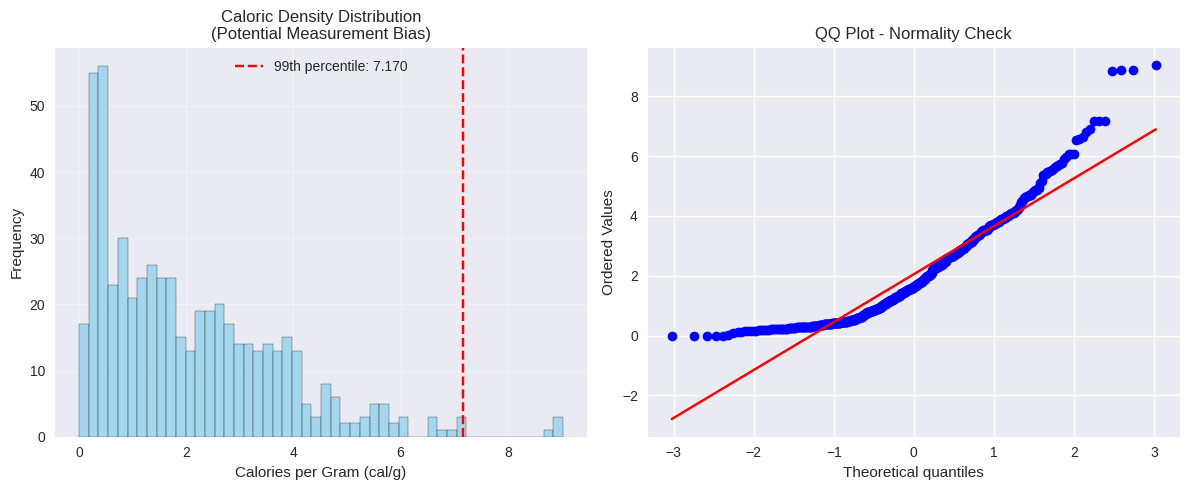


2. NUTRITIONAL REPRESENTATION BIAS
----------------------------------------
• Macronutrient Category Distribution:
  High Carb: 276 dishes (49.7%)
  High Protein: 133 dishes (24.0%)
  Balanced: 84 dishes (15.1%)
  High Fat: 61 dishes (11.0%)
  High Carb (Low Fat/Protein): 1 dishes (0.2%)


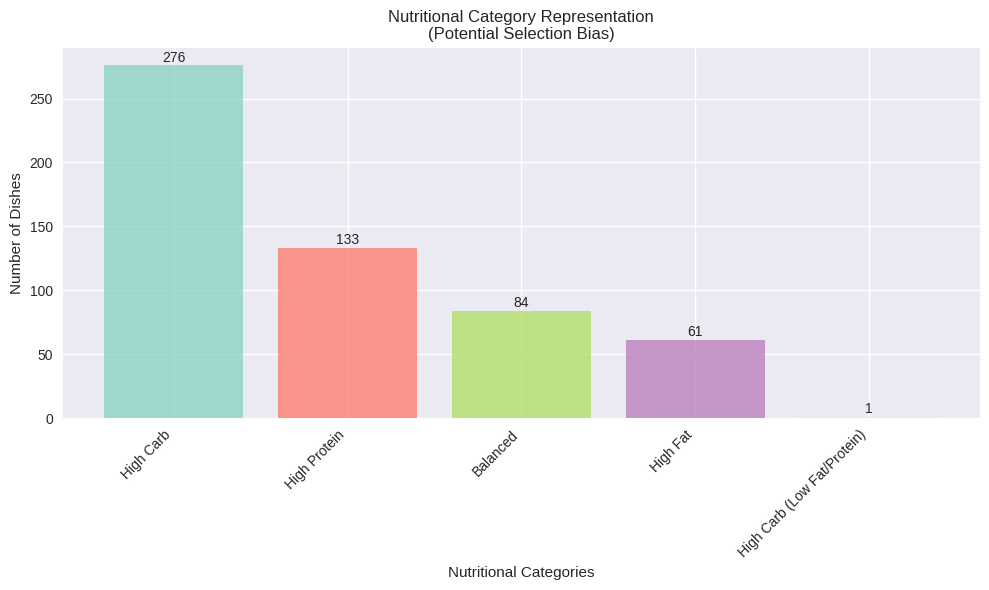

⚠️  WARNING: Potential bias - Limited 'Balanced' nutritional profiles

3. CULTURAL AND GEOGRAPHIC BIAS
----------------------------------------
• Average Macronutrient Profile (Potential Western Bias):
  Fat: 20.2%
  Carbohydrates: 55.0%
  Protein: 24.8%
\• Comparison with Global Dietary Patterns:
  Typical Western diet: Higher fat, moderate protein, varied carbs
  Asian diets: Often higher carbs (rice-based), lower fat
  Mediterranean: Balanced, higher healthy fats
  NOTE: Nutrition5k likely overrepresents Western cafeteria food

4. CALORIC DENSITY BIAS
----------------------------------------
• Distribution Skewness: 1.158
• Distribution Kurtosis: 1.439
⚠️  WARNING: Strong skew (1.158) indicates potential bias in caloric representation


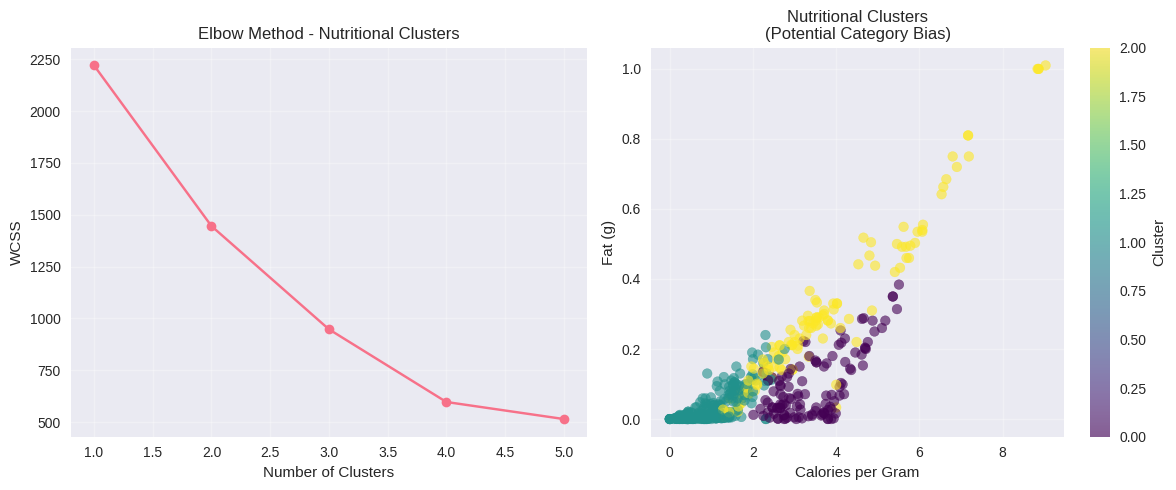

• Cluster Sizes: {0: np.int64(116), 1: np.int64(309), 2: np.int64(130)}

5. MEASUREMENT AND METHODOLOGY BIAS
----------------------------------------
• Laboratory Measurement Biases:
  - Controlled environment may not reflect real-world cooking variations
  - Standardized portions don't represent actual serving size variability
  - Laboratory precision may overstate real-world accuracy

• Sampling Methodology Biases:
  - Cafeteria setting limits diversity of cooking styles
  - Limited ethnic and cultural food representation
  - Potential bias toward commercially available ingredients

6. REAL-WORLD APPLICABILITY BIAS
----------------------------------------
• Potential Gaps vs Real-World Food Data:
  - Limited home-style cooking representation
  - Missing regional and traditional preparation methods
  - Underrepresentation of street foods and casual dining
  - Limited seasonal and ingredient variability

7. STATISTICAL BIAS QUANTIFICATION
----------------------------------------
• Coef

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def analyze_nutrition5k_biases(nutrition_df):
    """Comprehensive bias analysis for Nutrition5k dataset"""

    print("🔍 NUTRITION5K BIAS AWARENESS ANALYSIS")
    print("="*60)

    # 1. DATA COLLECTION BIAS ANALYSIS
    print("\n1. DATA COLLECTION BIAS ANALYSIS")
    print("-" * 40)

    # Analyze nutritional value ranges for potential selection bias
    if 'cal/g' in nutrition_df.columns:
        cal_density = nutrition_df['cal/g'].dropna()

        # Check for extreme values that might indicate lab measurement bias
        extreme_cal_threshold = cal_density.quantile(0.99)
        extreme_cal_dishes = nutrition_df[nutrition_df['cal/g'] > extreme_cal_threshold]

        print(f"• Caloric Density Range: {cal_density.min():.3f} - {cal_density.max():.3f} cal/g")
        print(f"• Extreme values (>99th percentile): {len(extreme_cal_dishes)} dishes")
        print(f"• Potential lab measurement outliers: {len(extreme_cal_dishes)} dishes")

        # Visualize distribution with extreme values highlighted
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.hist(cal_density, bins=50, alpha=0.7, edgecolor='black', color='skyblue')
        plt.axvline(extreme_cal_threshold, color='red', linestyle='--',
                   label=f'99th percentile: {extreme_cal_threshold:.3f}')
        plt.xlabel('Calories per Gram (cal/g)')
        plt.ylabel('Frequency')
        plt.title('Caloric Density Distribution\n(Potential Measurement Bias)')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # QQ plot for normality check
        plt.subplot(1, 2, 2)
        stats.probplot(cal_density, dist="norm", plot=plt)
        plt.title('QQ Plot - Normality Check')

        plt.tight_layout()
        plt.show()

    # 2. NUTRITIONAL REPRESENTATION BIAS
    print("\n2. NUTRITIONAL REPRESENTATION BIAS")
    print("-" * 40)

    if all(col in nutrition_df.columns for col in ['fat(g)', 'carb(g)', 'protein(g)']):
        # Calculate macronutrient percentages
        nutrition_clean = nutrition_df[['fat(g)', 'carb(g)', 'protein(g)']].dropna()
        total_macros = nutrition_clean.sum(axis=1)

        fat_pct = (nutrition_clean['fat(g)'] / total_macros) * 100
        carb_pct = (nutrition_clean['carb(g)'] / total_macros) * 100
        protein_pct = (nutrition_clean['protein(g)'] / total_macros) * 100

        # Analyze representation across nutritional categories
        def get_nutrition_category(fat, carb, protein):
            if protein > 35:
                return 'High Protein'
            elif fat > 40:
                return 'High Fat'
            elif carb > 65:
                return 'High Carb'
            elif fat < 20 and protein < 20:
                return 'High Carb (Low Fat/Protein)'
            else:
                return 'Balanced'

        categories = [get_nutrition_category(f, c, p) for f, c, p in zip(fat_pct, carb_pct, protein_pct)]
        category_counts = pd.Series(categories).value_counts()

        print("• Macronutrient Category Distribution:")
        for category, count in category_counts.items():
            percentage = (count / len(categories)) * 100
            print(f"  {category}: {count} dishes ({percentage:.1f}%)")

        # Visualize category distribution
        plt.figure(figsize=(10, 6))
        colors = plt.cm.Set3(np.linspace(0, 1, len(category_counts)))
        bars = plt.bar(category_counts.index, category_counts.values, color=colors, alpha=0.8)

        plt.xlabel('Nutritional Categories')
        plt.ylabel('Number of Dishes')
        plt.title('Nutritional Category Representation\n(Potential Selection Bias)')
        plt.xticks(rotation=45, ha='right')

        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                    f'{height}', ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

        # Check for missing nutritional profiles
        missing_balanced = 'Balanced' not in category_counts.index or category_counts['Balanced'] < len(categories) * 0.2
        if missing_balanced:
            print("⚠️  WARNING: Potential bias - Limited 'Balanced' nutritional profiles")

    # 3. CULTURAL AND GEOGRAPHIC BIAS
    print("\n3. CULTURAL AND GEOGRAPHIC BIAS")
    print("-" * 40)

    # Analyze potential Western cuisine bias through nutritional patterns
    if all(col in nutrition_df.columns for col in ['fat(g)', 'carb(g)', 'protein(g)']):
        # Typical Western diet patterns vs global patterns
        western_fat_avg = fat_pct.mean()
        western_carb_avg = carb_pct.mean()
        western_protein_avg = protein_pct.mean()

        print("• Average Macronutrient Profile (Potential Western Bias):")
        print(f"  Fat: {western_fat_avg:.1f}%")
        print(f"  Carbohydrates: {western_carb_avg:.1f}%")
        print(f"  Protein: {western_protein_avg:.1f}%")

        # Compare with typical global patterns
        print("\• Comparison with Global Dietary Patterns:")
        print("  Typical Western diet: Higher fat, moderate protein, varied carbs")
        print("  Asian diets: Often higher carbs (rice-based), lower fat")
        print("  Mediterranean: Balanced, higher healthy fats")
        print("  NOTE: Nutrition5k likely overrepresents Western cafeteria food")

    # 4. CALORIC DENSITY BIAS
    print("\n4. CALORIC DENSITY BIAS")
    print("-" * 40)

    if 'cal/g' in nutrition_df.columns:
        cal_density = nutrition_df['cal/g'].dropna()

        # Analyze distribution skew
        skewness = stats.skew(cal_density)
        kurtosis = stats.kurtosis(cal_density)

        print(f"• Distribution Skewness: {skewness:.3f}")
        print(f"• Distribution Kurtosis: {kurtosis:.3f}")

        if abs(skewness) > 1:
            print(f"⚠️  WARNING: Strong skew ({skewness:.3f}) indicates potential bias in caloric representation")
        if kurtosis > 3:
            print(f"⚠️  WARNING: High kurtosis ({kurtosis:.3f}) - distribution has heavy tails")

        # Analyze caloric density clusters
        from sklearn.cluster import KMeans
        from sklearn.preprocessing import StandardScaler

        # Prepare data for clustering
        cluster_data = nutrition_df[['cal/g', 'fat(g)', 'carb(g)', 'protein(g)']].dropna()
        if len(cluster_data) > 10:
            scaler = StandardScaler()
            scaled_data = scaler.fit_transform(cluster_data)

            # Find optimal clusters
            wcss = []
            for i in range(1, 6):
                kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
                kmeans.fit(scaled_data)
                wcss.append(kmeans.inertia_)

            plt.figure(figsize=(12, 5))

            plt.subplot(1, 2, 1)
            plt.plot(range(1, 6), wcss, marker='o')
            plt.xlabel('Number of Clusters')
            plt.ylabel('WCSS')
            plt.title('Elbow Method - Nutritional Clusters')
            plt.grid(True, alpha=0.3)

            # Perform clustering with 3 clusters
            kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
            clusters = kmeans.fit_predict(scaled_data)

            plt.subplot(1, 2, 2)
            scatter = plt.scatter(cluster_data['cal/g'], cluster_data['fat(g)'],
                                c=clusters, cmap='viridis', alpha=0.6)
            plt.xlabel('Calories per Gram')
            plt.ylabel('Fat (g)')
            plt.title('Nutritional Clusters\n(Potential Category Bias)')
            plt.colorbar(scatter, label='Cluster')
            plt.grid(True, alpha=0.3)

            plt.tight_layout()
            plt.show()

            cluster_sizes = pd.Series(clusters).value_counts().sort_index()
            print(f"• Cluster Sizes: {dict(cluster_sizes)}")
            if max(cluster_sizes) > len(clusters) * 0.6:
                print("⚠️  WARNING: One cluster dominates - potential category bias")

    # 5. MEASUREMENT AND METHODOLOGY BIAS
    print("\n5. MEASUREMENT AND METHODOLOGY BIAS")
    print("-" * 40)

    print("• Laboratory Measurement Biases:")
    print("  - Controlled environment may not reflect real-world cooking variations")
    print("  - Standardized portions don't represent actual serving size variability")
    print("  - Laboratory precision may overstate real-world accuracy")

    print("\n• Sampling Methodology Biases:")
    print("  - Cafeteria setting limits diversity of cooking styles")
    print("  - Limited ethnic and cultural food representation")
    print("  - Potential bias toward commercially available ingredients")

    # 6. COMPARISON WITH REAL-WORLD DATA BIAS
    print("\n6. REAL-WORLD APPLICABILITY BIAS")
    print("-" * 40)

    # Compare with known dietary databases
    print("• Potential Gaps vs Real-World Food Data:")
    print("  - Limited home-style cooking representation")
    print("  - Missing regional and traditional preparation methods")
    print("  - Underrepresentation of street foods and casual dining")
    print("  - Limited seasonal and ingredient variability")

    # 7. STATISTICAL BIAS QUANTIFICATION
    print("\n7. STATISTICAL BIAS QUANTIFICATION")
    print("-" * 40)

    if all(col in nutrition_df.columns for col in ['fat(g)', 'carb(g)', 'protein(g)', 'cal/g']):
        # Calculate coefficient of variation for each nutrient
        nutrients = ['fat(g)', 'carb(g)', 'protein(g)', 'cal/g']
        cv_scores = {}

        for nutrient in nutrients:
            if nutrient in nutrition_df.columns:
                data = nutrition_df[nutrient].dropna()
                cv = data.std() / data.mean() if data.mean() != 0 else 0
                cv_scores[nutrient] = cv

        print("• Coefficient of Variation (Higher = More Variability):")
        for nutrient, cv in cv_scores.items():
            print(f"  {nutrient}: {cv:.3f}")

        # Identify potential homogenization
        low_variability = [nut for nut, cv in cv_scores.items() if cv < 0.3]
        if low_variability:
            print(f"⚠️  WARNING: Low variability in {low_variability} - potential homogenization bias")

    # 8. IMPACT ASSESSMENT ON YOUR RESEARCH
    print("\n8. IMPACT ON SAUDI CUISINE COMPARISON")
    print("-" * 40)

    print("• Potential Comparison Biases:")
    print("  - Western vs Middle Eastern cooking techniques")
    print("  - Different ingredient availability and preferences")
    print("  - Cultural differences in portion sizes and plating")
    print("  - Variation in spice and seasoning usage")

    print("\n• Mitigation Strategies:")
    print("  - Focus on relative patterns rather than absolute values")
    print("  - Acknowledge cultural differences in interpretation")
    print("  - Use Nutrition5k as baseline, not ground truth")
    print("  - Supplement with Saudi-specific nutritional knowledge")

    # 9. SUMMARY OF KEY BIASES
    print("\n" + "="*60)
    print("SUMMARY OF KEY BIASES IN NUTRITION5K DATASET")
    print("="*60)

    biases = [
        "1. WESTERN CUISINE BIAS: Overrepresentation of Western/American foods",
        "2. LABORATORY BIAS: Controlled conditions vs real-world variability",
        "3. CAFETERIA BIAS: Limited to institutional cooking styles",
        "4. PORTION BIAS: Standardized sizes don't reflect actual consumption",
        "5. CULTURAL BIAS: Underrepresentation of ethnic and traditional foods",
        "6. INGREDIENT BIAS: Limited seasonal and regional ingredient variety",
        "7. MEASUREMENT BIAS: Laboratory precision overstates real accuracy",
        "8. SELECTION BIAS: May overrepresent photogenic or common dishes"
    ]

    for bias in biases:
        print(f"• {bias}")

    print("\n" + "🎯 RECOMMENDATIONS FOR YOUR RESEARCH:")
    print("  - Acknowledge these biases in your methodology section")
    print("  - Use Nutrition5k as a comparative baseline, not absolute truth")
    print("  - Focus on pattern recognition rather than direct nutritional transfer")
    print("  - Supplement with Saudi-specific nutritional knowledge")
    print("  - Consider cultural context in all comparisons")

def generate_bias_report(nutrition_df):
    """Generate a comprehensive bias awareness report"""

    print("\n" + "🔬 COMPREHENSIVE BIAS AWARENESS REPORT")
    print("="*70)

    # Data Collection Context
    print("\nCONTEXTUAL BACKGROUND:")
    print("• Dataset: Nutrition5k Research Dataset")
    print("• Collection: Laboratory analysis in controlled settings")
    print("• Primary Use: Computer vision nutrition estimation research")
    print("• Geographic Origin: Likely US/Western institutions")

    # Key Limitations
    print("\nKEY LIMITATIONS AFFECTING INTERPRETATION:")
    print("1. CULTURAL HOMOGENEITY: Dominantly Western/American food styles")
    print("2. PREPARATION UNIFORMITY: Standardized lab conditions")
    print("3. SAMPLING RESTRICTIONS: Cafeteria/institutional focus")
    print("4. MEASUREMENT IDEALIZATION: Laboratory precision vs real-world variance")

    # Research Implications
    print("\nRESEARCH IMPLICATIONS FOR YOUR STUDY:")
    print("✓ Use for methodological comparison, not cultural transfer")
    print("✓ Acknowledge Western bias when comparing with Saudi cuisine")
    print("✓ Focus on relative patterns rather than absolute nutritional values")
    print("✓ Supplement with cultural context in all findings")

    return {
        'cultural_bias': 'High - Western cuisine dominance',
        'methodology_bias': 'Medium - Laboratory conditions',
        'sampling_bias': 'Medium - Institutional focus',
        'applicability_bias': 'High - Limited real-world transfer'
    }

# Main execution
if __name__ == "__main__":
    # Load your Nutrition5k metadata
    nutrition_df = pd.read_csv('./metadata/ingredients_metadata.csv')  # Adjust path as needed

    print("Starting Nutrition5k Bias Awareness Analysis...")
    analyze_nutrition5k_biases(nutrition_df)

    print("\n" + "="*70)
    bias_summary = generate_bias_report(nutrition_df)
    print("="*70)

--- Starting Nutrition5K Visual Composition Analysis ---
Loading images from ./rgb_samples_fixed/...
N5K Samples Loaded: 200 images.

--- Calculated Mean RGB Values (0-255) ---
Color Signature: R=118.43, G=114.50, B=110.16

--- Calculated Mean Texture Value (Edge Strength) ---
Texture Signature (0-1): 0.0404

Displaying Color Distribution bar chart (Plot 1)...


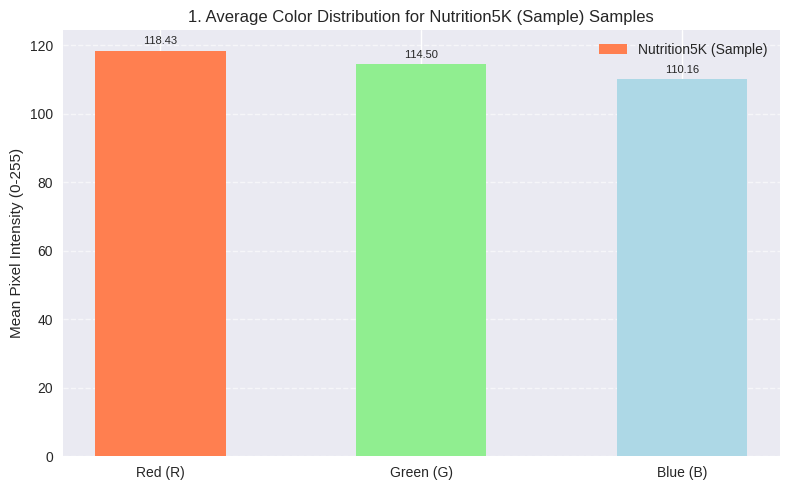

Displaying Texture Distribution bar chart (Plot 2)...


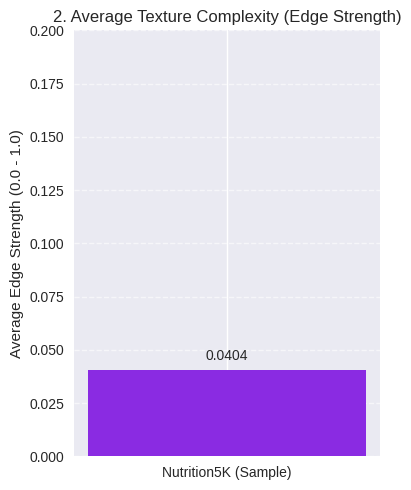

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage.io import imread # Used for loading image files
from skimage.transform import resize
from skimage.filters import sobel # Used for calculating image gradients (texture)

# --- Configuration ---
# 1. Nutrition5K Sample Dataset (The only dataset being analyzed)
N5K_SAMPLE_DIR = './rgb_samples_fixed/' # Directory where your N5K sample images were downloaded
N5K_NAME = 'Nutrition5K (Sample)'
TARGET_SIZE = (224, 224, 3) # Standard size for image analysis

# --- 1. Data Loading Function ---

def load_local_nutrition5k_samples():
    """Loads local N5K sample images from the fixed directory."""
    images = []

    # Check if the directory exists
    if not os.path.exists(N5K_SAMPLE_DIR):
        print(f"Error: N5K sample directory not found at {N5K_SAMPLE_DIR}")
        return np.array([])

    print(f"Loading images from {N5K_SAMPLE_DIR}...")

    # Iterate through all files in the directory
    for filename in os.listdir(N5K_SAMPLE_DIR):
        if filename.endswith(".png"): # Assuming the samples are .png
            filepath = os.path.join(N5K_SAMPLE_DIR, filename)
            try:
                # Load image (skimage.io.imread handles different formats and returns np array)
                img = imread(filepath)
                # Resize the image to match a standard size (essential for analysis)
                img_resized = resize(img, TARGET_SIZE, anti_aliasing=True, preserve_range=True)

                # Ensure the image has 3 color channels (e.g., handles 4-channel PNGs or grayscale conversion)
                if img_resized.ndim == 3 and img_resized.shape[-1] == 4: # Handle PNGs with alpha channel
                     img_resized = img_resized[:, :, :3]
                elif img_resized.ndim == 2: # Handle grayscale images (1 channel)
                    # Stack the single channel 3 times to create an RGB image
                    img_resized = np.stack([img_resized, img_resized, img_resized], axis=-1)

                # Ensure the final output is uint8 (0-255 range)
                images.append(img_resized.astype(np.uint8))
            except Exception as e:
                print(f"Could not load or process image {filename}: {e}")

    return np.array(images)


# --- 2. Analysis Functions ---

def calculate_mean_rgb(image_array):
    """Calculates the average R, G, and B values across the entire dataset."""
    if image_array.size == 0:
        return {'R': 0, 'G': 0, 'B': 0}

    # Normalize pixel values to 0-1 range for accurate averaging
    image_array = image_array.astype(np.float32) / 255.0

    # Calculate the mean across all dimensions except the channel dimension (axis 3)
    mean_rgb = np.mean(image_array, axis=(0, 1, 2))

    # Convert back to the 0-255 range for easier interpretation
    return {
        'R': mean_rgb[0] * 255,
        'G': mean_rgb[1] * 255,
        'B': mean_rgb[2] * 255
    }

def calculate_mean_texture(image_array):
    """
    Calculates the average texture strength (edge magnitude) using the Sobel operator.
    Higher values indicate more sharp, complex, or varied textures.
    """
    if image_array.size == 0:
        return 0.0

    # Convert array to grayscale first, as Sobel is most reliably applied to a single channel
    grayscale_array = np.mean(image_array, axis=3) / 255.0 # Normalize to 0-1 float range

    texture_magnitudes = []

    # Iterate over each image in the dataset
    for img_gray in grayscale_array:
        # Calculate the magnitude of the image gradient (edge strength)
        edges = sobel(img_gray)
        texture_magnitudes.append(np.mean(edges))

    # Return the mean texture strength across all images
    return np.mean(texture_magnitudes)


# --- 3. Visualization Functions (Separated) ---

def visualize_color_distribution(n5k_rgb):
    """Generates a bar chart showing the mean RGB values for the N5K dataset."""

    channels = ['Red (R)', 'Green (G)', 'Blue (B)']
    n5k_values = [n5k_rgb['R'], n5k_rgb['G'], n5k_rgb['B']]
    x = np.arange(len(channels))
    width = 0.5

    fig, ax = plt.subplots(figsize=(8, 5))
    rects = ax.bar(x, n5k_values, width, label=N5K_NAME, color=['#FF7F50', '#90EE90', '#ADD8E6'])

    ax.set_ylabel('Mean Pixel Intensity (0-255)')
    ax.set_title(f'1. Average Color Distribution for {N5K_NAME} Samples')
    ax.set_xticks(x)
    ax.set_xticklabels(channels)
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.6)

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom',
                        fontsize=8)

    autolabel(rects)

    fig.tight_layout()
    plt.show()

def visualize_texture_distribution(n5k_texture):
    """Generates a bar chart showing the mean texture magnitude for the N5K dataset."""

    fig, ax = plt.subplots(figsize=(4, 5))
    bar = ax.bar([N5K_NAME], [n5k_texture], color='#8A2BE2')

    ax.set_ylabel('Average Edge Strength (0.0 - 1.0)')
    ax.set_title('2. Average Texture Complexity (Edge Strength)')
    ax.set_ylim(0, 0.2)
    ax.grid(axis='y', linestyle='--', alpha=0.6)

    for rect in bar:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 5),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=10)

    fig.tight_layout()
    plt.show()


# --- Main Execution ---

print("--- Starting Nutrition5K Visual Composition Analysis ---")

# 1. Load Nutrition5k Sample Data
n5k_samples = load_local_nutrition5k_samples()
if n5k_samples.size == 0:
    print("Cannot proceed with N5K sample data. Check your sample folder.")
    exit()

print(f"N5K Samples Loaded: {n5k_samples.shape[0]} images.")

# 2. Calculate Mean RGB (Color)
n5k_mean_rgb = calculate_mean_rgb(n5k_samples)
print("\n--- Calculated Mean RGB Values (0-255) ---")
print(f"Color Signature: R={n5k_mean_rgb['R']:.2f}, G={n5k_mean_rgb['G']:.2f}, B={n5k_mean_rgb['B']:.2f}")

# 3. Calculate Mean Texture (Edge Strength)
n5k_mean_texture = calculate_mean_texture(n5k_samples)
print("\n--- Calculated Mean Texture Value (Edge Strength) ---")
print(f"Texture Signature (0-1): {n5k_mean_texture:.4f}")


# 4. Visualize Results (Separated Plots)
print("\nDisplaying Color Distribution bar chart (Plot 1)...")
visualize_color_distribution(n5k_mean_rgb)

print("Displaying Texture Distribution bar chart (Plot 2)...")
visualize_texture_distribution(n5k_mean_texture)


# PRIMARY DATA

--- ENHANCED SAUDI CUISINE COMPREHENSIVE EDA ---
Dataset Overview: 278 records, 228 unique dishes

Performing comprehensive EDA...

INGREDIENT PATTERN DISCOVERY


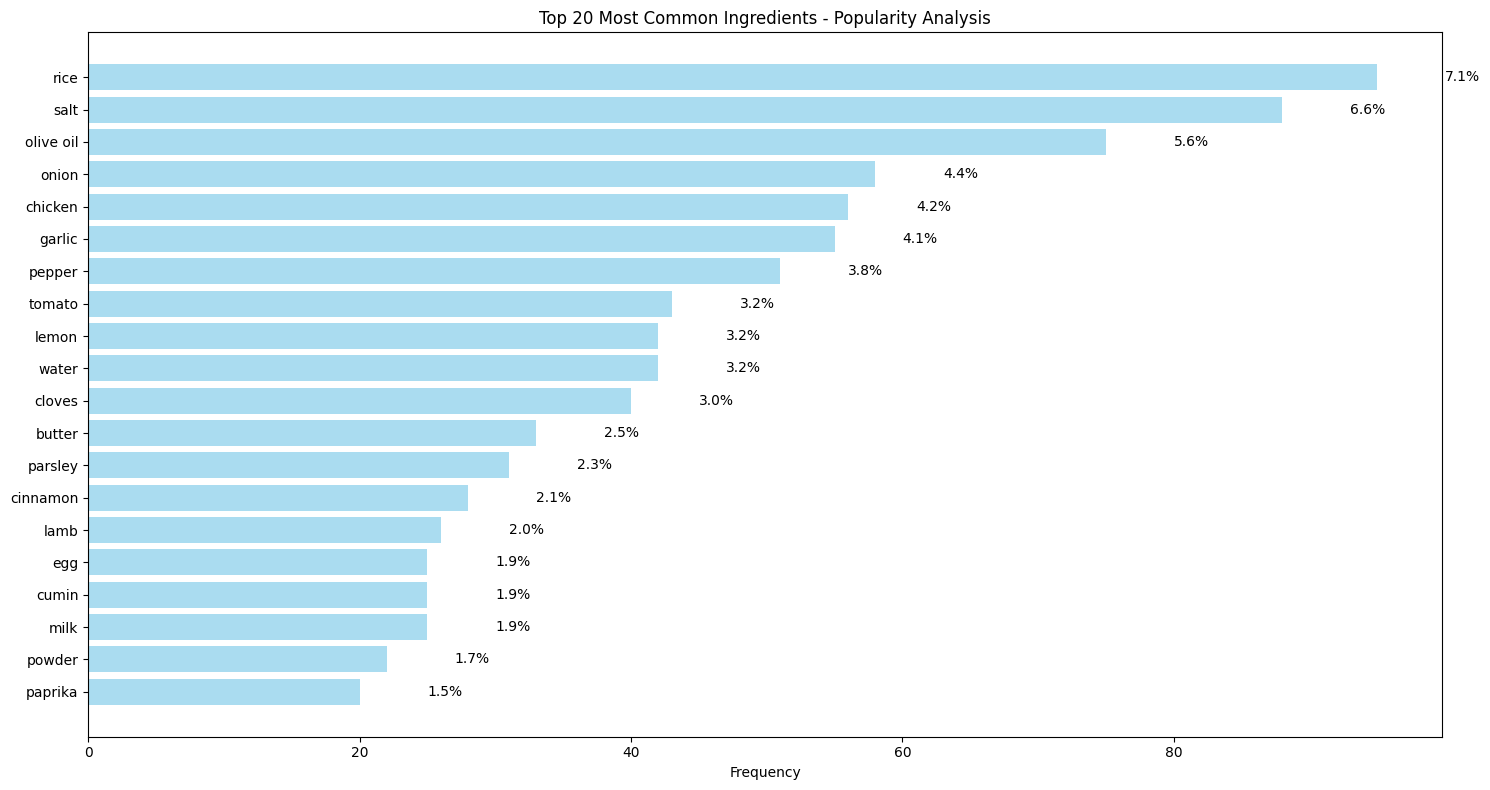

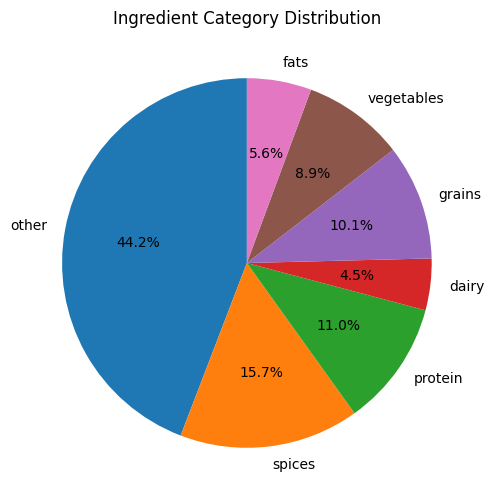


TEMPORAL TREND ANALYSIS


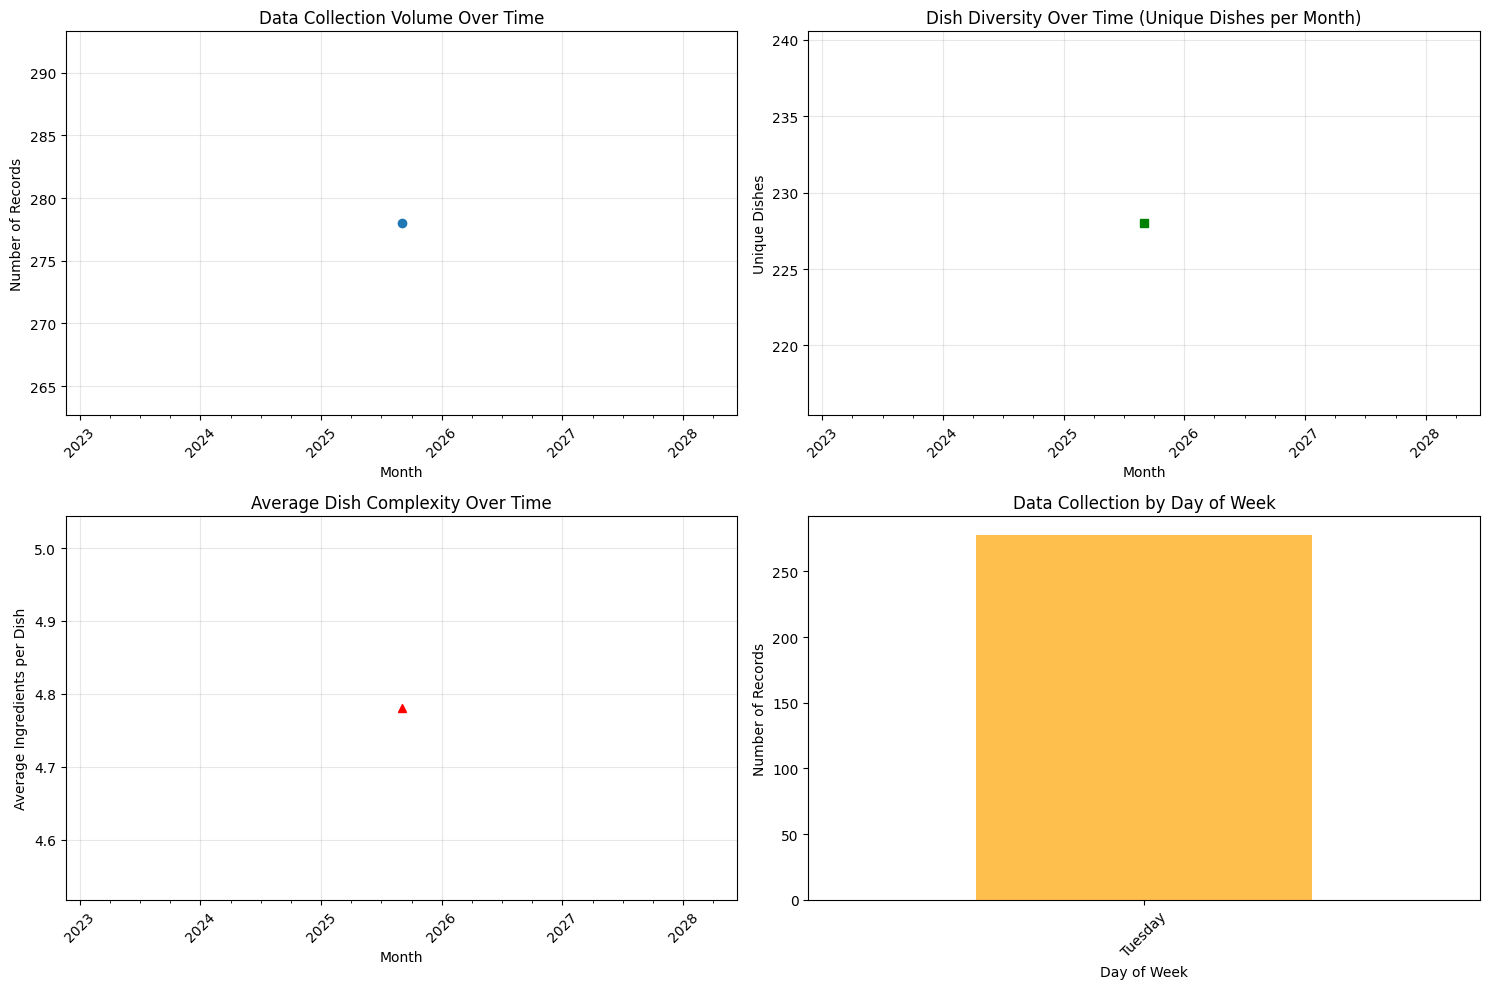


ANOMALY DETECTION
Ingredient Count Anomalies: 25 dishes
Dishes with unusual ingredient counts:
  - Kabsa: 20 ingredients
  - Basbousa: 14 ingredients
  - Bu meat rice the Hijazi way: 14 ingredients
  - Braised Chuck Roast: 14 ingredients
  - Jaj Mahshi: 14 ingredients
  - Lamb Tagine: 17 ingredients
  - Mansaf: 15 ingredients
  - Ouzi: 14 ingredients
  - Chicken Shawarma Bowl: 18 ingredients
  - Chipotle Chicken Bowl: 16 ingredients
  - Cart Chicken: 21 ingredients
  - Maqluba With Lamb: 17 ingredients
  - Leg Of Lamb: 17 ingredients
  - Beef Shawarma: 22 ingredients
  - Middle Eastern Grilled Chicken: 15 ingredients
  - Cottage: 18 ingredients
  - Stuffed Eggplant Boats: 15 ingredients
  - Maqluba: 16 ingredients
  - Sayadieh: 15 ingredients
  - Falafel Sandwiches: 15 ingredients
  - Mujaddara: 14 ingredients
  - Dough: 15 ingredients
  - Shish Barak: 15 ingredients
  - Chicken & Flatbread: 18 ingredients
  - Vegetarian Stuffed Grape Leaves: 15 ingredients

Duplicate Dish Names: 27 d

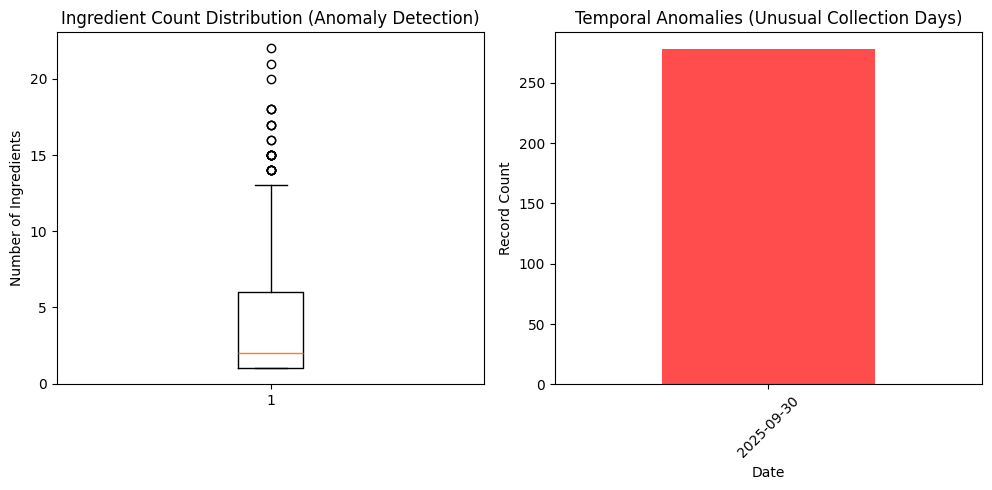


CORRELATION ANALYSIS


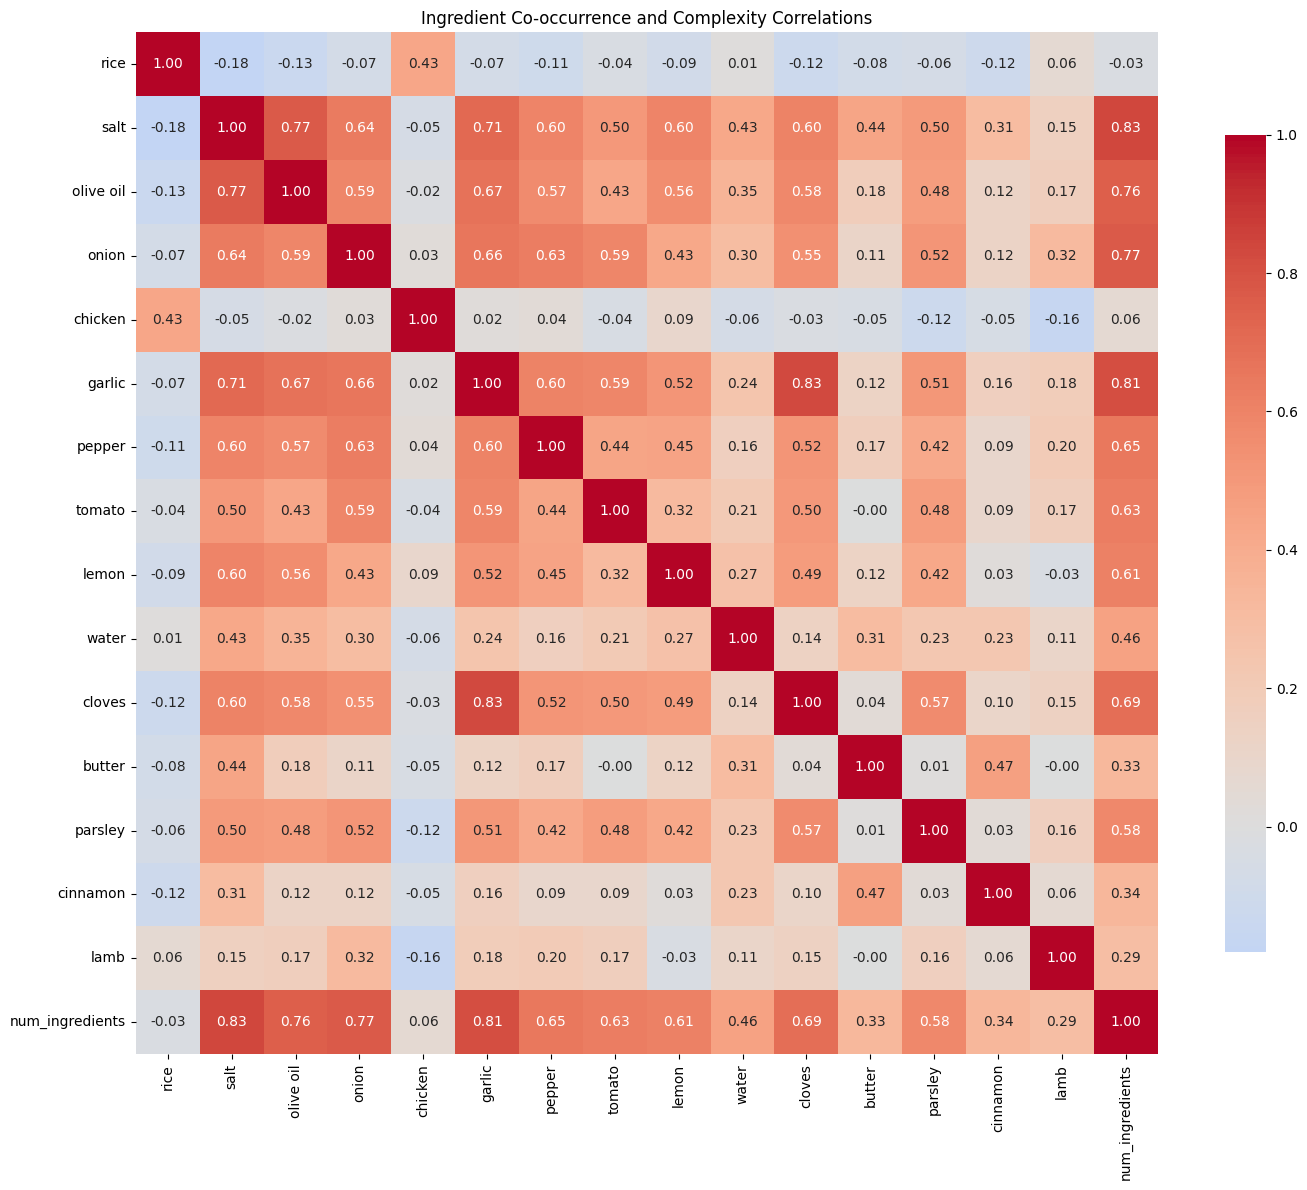

Strongest Positive Correlations:
  salt <-> num_ingredients: 0.834
  garlic <-> cloves: 0.825
  garlic <-> num_ingredients: 0.811
  salt <-> olive oil: 0.771
  onion <-> num_ingredients: 0.767
  olive oil <-> num_ingredients: 0.755
  salt <-> garlic: 0.710
  cloves <-> num_ingredients: 0.691
  olive oil <-> garlic: 0.675
  onion <-> garlic: 0.656

DISH CLUSTER ANALYSIS


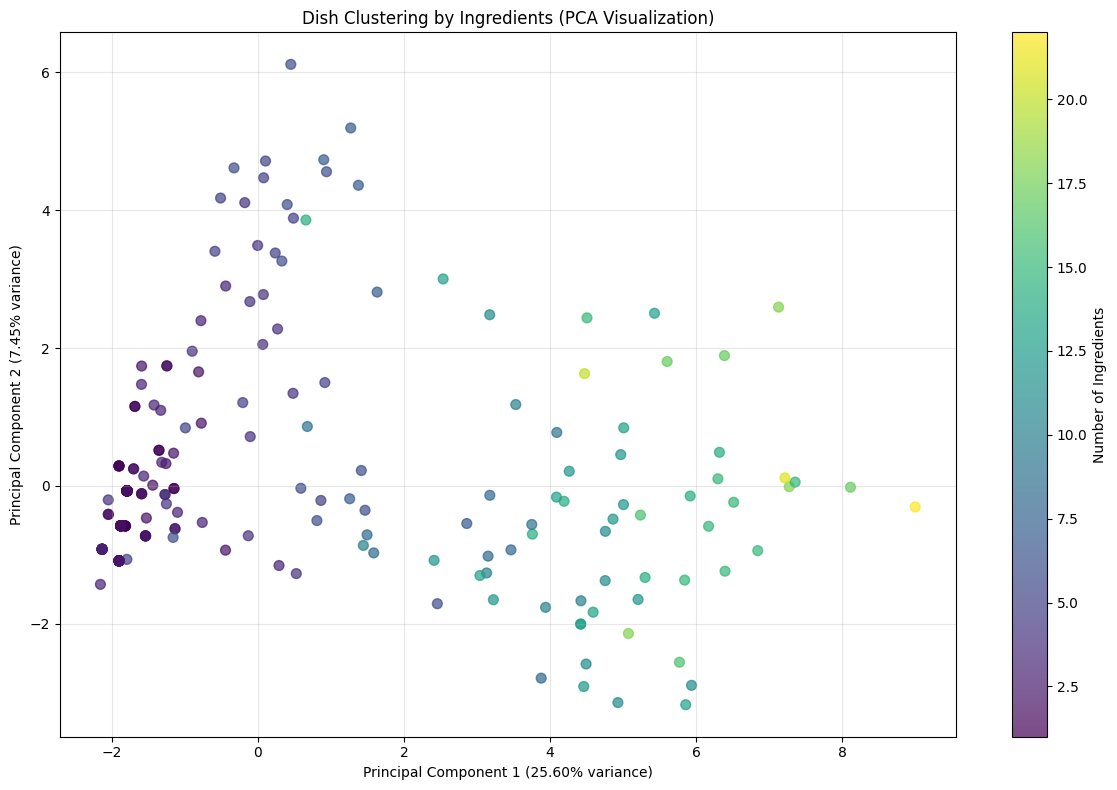

PCA Explained Variance: 33.05%

Dish Complexity Groups:
                num_ingredients              dish_name
                          count   mean   std   nunique
num_ingredients                                       
Simple                      222   2.56  1.83       179
Medium                       45  12.44  1.84        44
Complex                      11  18.18  1.99        11

COMPREHENSIVE EDA INSIGHTS AND PATTERNS
KEY PATTERNS:
  * Average dish complexity: 4.8 ingredients
  * Most popular dish: 'Kabsa'
  * Most common ingredient: 'rice'
  * Dish diversity: 228 unique dishes

TRENDS:
  * Data collection spanned 0 days
  * Average 278.0 records collected per day
  * Collection period: 2025-09-30 to 2025-09-30

ANOMALIES DETECTED:
  * 25 dishes with unusual ingredient counts
  * 27 dishes have duplicate entries
  * 1 days with unusual collection patterns

DATA QUALITY:
  * Completeness: 100.0% image coverage
  * Ingredient data: 278/278 dishes have ingredients
  * Unique ingredie

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import ast
from collections import Counter
import zipfile
from datetime import datetime
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Load and prepare your data
def load_and_prepare_data():
    """Load and prepare the Saudi food dataset"""
    df = pd.read_csv('SaudiFoodFile_standardized_consistentM.csv')

    # Function to safely convert string representation of list to actual list
    def safe_literal_eval(val):
        if isinstance(val, list):
            return val
        try:
            return ast.literal_eval(val)
        except (ValueError, SyntaxError):
            return [str(val)] if pd.notna(val) else []

    # Apply the conversion
    df['ingredients_list'] = df['classifications_std_list'].apply(safe_literal_eval)
    df['num_ingredients'] = df['ingredients_list'].apply(len)

    return df

# --- Enhanced Analysis Functions ---

def discover_ingredient_patterns(df):
    """Discover patterns and trends in ingredient usage"""
    print("\n" + "="*60)
    print("INGREDIENT PATTERN DISCOVERY")
    print("="*60)

    all_ingredients = []
    for ingredients in df['ingredients_list']:
        all_ingredients.extend(ingredients)

    ingredient_counts = Counter(all_ingredients)

    # 1. Ingredient popularity trends
    top_20_ingredients = ingredient_counts.most_common(20)
    ingredients, counts = zip(*top_20_ingredients)

    plt.figure(figsize=(15, 8))
    bars = plt.barh(range(len(ingredients)), counts, color='skyblue', alpha=0.7)
    plt.yticks(range(len(ingredients)), ingredients)
    plt.xlabel('Frequency')
    plt.title('Top 20 Most Common Ingredients - Popularity Analysis')
    plt.gca().invert_yaxis()

    # Add percentage labels
    total_ingredient_occurrences = sum(ingredient_counts.values())
    for i, bar in enumerate(bars):
        width = bar.get_width()
        percentage = (width / total_ingredient_occurrences) * 100
        plt.text(width + 5, bar.get_y() + bar.get_height()/2,
                f'{percentage:.1f}%', ha='left', va='center')

    plt.tight_layout()
    plt.show()

    # 2. Ingredient category analysis
    def categorize_ingredient(ingredient):
        ingredient_lower = ingredient.lower()
        categories = {
            'protein': ['chicken', 'lamb', 'meat', 'beef', 'fish', 'shrimp', 'egg'],
            'grains': ['rice', 'wheat', 'flour', 'bread', 'dough'],
            'vegetables': ['onion', 'tomato', 'potato', 'carrot', 'cucumber', 'lettuce'],
            'spices': ['salt', 'pepper', 'cumin', 'cinnamon', 'cardamom', 'saffron'],
            'dairy': ['yogurt', 'milk', 'cheese', 'butter'],
            'fats': ['oil', 'ghee', 'butter', 'margarine']
        }

        for category, keywords in categories.items():
            if any(keyword in ingredient_lower for keyword in keywords):
                return category
        return 'other'

    df['ingredient_categories'] = df['ingredients_list'].apply(
        lambda x: [categorize_ingredient(ing) for ing in x]
    )

    # Count categories
    all_categories = []
    for categories in df['ingredient_categories']:
        all_categories.extend(categories)

    category_counts = Counter(all_categories)

    plt.figure(figsize=(12, 6))
    plt.pie(category_counts.values(), labels=category_counts.keys(), autopct='%1.1f%%', startangle=90)
    plt.title('Ingredient Category Distribution')
    plt.show()

    return ingredient_counts, category_counts

def analyze_temporal_trends(df):
    """Analyze trends and patterns over time"""
    print("\n" + "="*60)
    print("TEMPORAL TREND ANALYSIS")
    print("="*60)

    # Convert scrape_date to datetime and extract features
    df['scrape_date'] = pd.to_datetime(df['scrape_date'])
    df['scrape_month'] = df['scrape_date'].dt.to_period('M')
    df['scrape_week'] = df['scrape_date'].dt.isocalendar().week

    # Monthly trends
    monthly_counts = df.groupby('scrape_month').size()

    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    monthly_counts.plot(kind='line', marker='o', linewidth=2, markersize=6)
    plt.title('Data Collection Volume Over Time')
    plt.xlabel('Month')
    plt.ylabel('Number of Records')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

    # Dish diversity over time
    monthly_diversity = df.groupby('scrape_month')['dish_name'].nunique()

    plt.subplot(2, 2, 2)
    monthly_diversity.plot(kind='line', marker='s', color='green', linewidth=2, markersize=6)
    plt.title('Dish Diversity Over Time (Unique Dishes per Month)')
    plt.xlabel('Month')
    plt.ylabel('Unique Dishes')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

    # Complexity trends
    monthly_complexity = df.groupby('scrape_month')['num_ingredients'].mean()

    plt.subplot(2, 2, 3)
    monthly_complexity.plot(kind='line', marker='^', color='red', linewidth=2, markersize=6)
    plt.title('Average Dish Complexity Over Time')
    plt.xlabel('Month')
    plt.ylabel('Average Ingredients per Dish')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

    # Weekly patterns
    daily_counts = df['scrape_date'].dt.day_name().value_counts()

    plt.subplot(2, 2, 4)
    daily_counts.plot(kind='bar', color='orange', alpha=0.7)
    plt.title('Data Collection by Day of Week')
    plt.xlabel('Day of Week')
    plt.ylabel('Number of Records')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    return monthly_counts, monthly_diversity, monthly_complexity

def detect_anomalies(df, visual_metrics=None):
    """Detect anomalies and outliers in the dataset"""
    print("\n" + "="*60)
    print("ANOMALY DETECTION")
    print("="*60)

    anomalies = {}

    # 1. Ingredient count anomalies
    ingredient_stats = df['num_ingredients'].describe()
    Q1 = ingredient_stats['25%']
    Q3 = ingredient_stats['75%']
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    ingredient_anomalies = df[
        (df['num_ingredients'] < lower_bound) |
        (df['num_ingredients'] > upper_bound)
    ]

    anomalies['ingredient_count'] = ingredient_anomalies
    print(f"Ingredient Count Anomalies: {len(ingredient_anomalies)} dishes")
    if len(ingredient_anomalies) > 0:
        print("Dishes with unusual ingredient counts:")
        for _, row in ingredient_anomalies[['dish_name', 'num_ingredients']].iterrows():
            print(f"  - {row['dish_name']}: {row['num_ingredients']} ingredients")

    # 2. Duplicate detection
    duplicate_dishes = df[df.duplicated(subset=['dish_name'], keep=False)]
    if len(duplicate_dishes) > 0:
        dish_groups = duplicate_dishes.groupby('dish_name').size()
        anomalies['duplicates'] = dish_groups[dish_groups > 1]
        print(f"\nDuplicate Dish Names: {len(anomalies['duplicates'])} dishes have multiple entries")
        print("Most frequent duplicates:")
        print(anomalies['duplicates'].head(10))

    # 3. Temporal anomalies
    if 'scrape_date' in df.columns:
        date_range = df['scrape_date'].max() - df['scrape_date'].min()
        avg_records_per_day = len(df) / date_range.days if date_range.days > 0 else 0

        daily_counts = df['scrape_date'].dt.date.value_counts()
        temporal_anomalies = daily_counts[
            (daily_counts > avg_records_per_day * 2) |
            (daily_counts < avg_records_per_day * 0.5)
        ]

        anomalies['temporal'] = temporal_anomalies
        print(f"\nTemporal Anomalies: {len(temporal_anomalies)} days with unusual activity")

    # 4. Visual anomalies (if available)
    if visual_metrics is not None:
        visual_df = pd.DataFrame(visual_metrics)

        # Detect visual outliers using Z-score
        visual_features = ['R', 'G', 'B', 'Texture']
        for feature in visual_features:
            if feature in visual_df.columns:
                z_scores = np.abs(stats.zscore(visual_df[feature]))
                visual_outliers = z_scores > 3
                if visual_outliers.any():
                    print(f"\nVisual Anomalies in {feature}: {visual_outliers.sum()} outliers detected")
                    anomalies[f'visual_{feature}'] = visual_outliers

    # Visualize anomalies
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.boxplot(df['num_ingredients'])
    plt.title('Ingredient Count Distribution (Anomaly Detection)')
    plt.ylabel('Number of Ingredients')

    if 'temporal' in anomalies and len(anomalies['temporal']) > 0:
        plt.subplot(1, 3, 2)
        anomalies['temporal'].plot(kind='bar', color='red', alpha=0.7)
        plt.title('Temporal Anomalies (Unusual Collection Days)')
        plt.xlabel('Date')
        plt.ylabel('Record Count')
        plt.xticks(rotation=45)

    if visual_metrics is not None and 'R' in visual_df.columns:
        plt.subplot(1, 3, 3)
        plt.scatter(visual_df['R'], visual_df['G'], alpha=0.6)
        if 'visual_R' in anomalies:
            outlier_indices = anomalies['visual_R']
            plt.scatter(visual_df['R'][outlier_indices], visual_df['G'][outlier_indices],
                       color='red', label='Visual Outliers', s=50)
            plt.legend()
        plt.xlabel('Red Intensity')
        plt.ylabel('Green Intensity')
        plt.title('Visual Feature Anomalies')

    plt.tight_layout()
    plt.show()

    return anomalies

def perform_correlation_analysis(df, visual_metrics=None):
    """Perform comprehensive correlation analysis"""
    print("\n" + "="*60)
    print("CORRELATION ANALYSIS")
    print("="*60)

    # 1. Ingredient complexity correlations
    complexity_correlations = {}

    # Create ingredient presence matrix for correlation
    all_ingredients = []
    for ingredients in df['ingredients_list']:
        all_ingredients.extend(ingredients)

    top_ingredients = [ing[0] for ing in Counter(all_ingredients).most_common(15)]

    # Create binary matrix for top ingredients
    ingredient_presence = {}
    for ingredient in top_ingredients:
        ingredient_presence[ingredient] = df['ingredients_list'].apply(
            lambda x: 1 if ingredient in x else 0
        )

    ingredient_df = pd.DataFrame(ingredient_presence)
    ingredient_df['num_ingredients'] = df['num_ingredients']

    # Calculate correlations
    corr_matrix = ingredient_df.corr()

    plt.figure(figsize=(15, 12))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f',
                square=True, cbar_kws={"shrink": .8})
    plt.title('Ingredient Co-occurrence and Complexity Correlations')
    plt.tight_layout()
    plt.show()

    # 2. Strongest correlations
    print("Strongest Positive Correlations:")
    strong_corrs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > 0.3:  # Threshold for strong correlation
                strong_corrs.append((
                    corr_matrix.columns[i],
                    corr_matrix.columns[j],
                    corr_matrix.iloc[i, j]
                ))

    strong_corrs.sort(key=lambda x: abs(x[2]), reverse=True)
    for corr in strong_corrs[:10]:
        print(f"  {corr[0]} <-> {corr[1]}: {corr[2]:.3f}")

    # 3. Visual-ingredient correlations (if available)
    if visual_metrics is not None and len(visual_metrics['R']) == len(df):
        visual_df = pd.DataFrame(visual_metrics)
        combined_df = pd.concat([df.reset_index(drop=True), visual_df], axis=1)

        # Select numerical columns for correlation
        numerical_cols = ['num_ingredients'] + list(visual_df.columns)
        visual_corr = combined_df[numerical_cols].corr()

        plt.figure(figsize=(10, 8))
        sns.heatmap(visual_corr, annot=True, cmap='RdYlBu', center=0, fmt='.2f')
        plt.title('Visual Feature vs Ingredient Complexity Correlations')
        plt.tight_layout()
        plt.show()

        print("\nVisual-Ingredient Correlations:")
        for visual_feat in visual_df.columns:
            corr_with_ingredients = visual_corr.loc['num_ingredients', visual_feat]
            print(f"  {visual_feat} vs Ingredient Count: {corr_with_ingredients:.3f}")

    return corr_matrix

def analyze_dish_clusters(df):
    """Cluster analysis to discover dish groups"""
    print("\n" + "="*60)
    print("DISH CLUSTER ANALYSIS")
    print("="*60)

    # Get top ingredients for clustering
    all_ingredients = []
    for ingredients in df['ingredients_list']:
        all_ingredients.extend(ingredients)

    top_30_ingredients = [ing[0] for ing in Counter(all_ingredients).most_common(30)]

    # Create ingredient matrix
    ingredient_matrix = []
    for ingredients in df['ingredients_list']:
        row = [1 if ing in ingredients else 0 for ing in top_30_ingredients]
        ingredient_matrix.append(row)

    ingredient_matrix = np.array(ingredient_matrix)

    # Simple clustering visualization using PCA
    if len(ingredient_matrix) > 2:
        # Reduce dimensions for visualization
        pca = PCA(n_components=2)
        scaled_data = StandardScaler().fit_transform(ingredient_matrix)
        principal_components = pca.fit_transform(scaled_data)

        plt.figure(figsize=(12, 8))
        scatter = plt.scatter(principal_components[:, 0], principal_components[:, 1],
                             c=df['num_ingredients'], cmap='viridis', alpha=0.7, s=50)
        plt.colorbar(scatter, label='Number of Ingredients')
        plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
        plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
        plt.title('Dish Clustering by Ingredients (PCA Visualization)')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        print(f"PCA Explained Variance: {pca.explained_variance_ratio_.sum():.2%}")

        # Identify dish groups by complexity
        complexity_groups = pd.cut(df['num_ingredients'], bins=3,
                                 labels=['Simple', 'Medium', 'Complex'])

        group_stats = df.groupby(complexity_groups).agg({
            'num_ingredients': ['count', 'mean', 'std'],
            'dish_name': 'nunique'
        }).round(2)

        print("\nDish Complexity Groups:")
        print(group_stats)

def generate_comprehensive_insights(df, ingredient_counts, anomalies, corr_matrix):
    """Generate comprehensive insights and patterns"""
    print("\n" + "="*70)
    print("COMPREHENSIVE EDA INSIGHTS AND PATTERNS")
    print("="*70)

    insights = []

    # 1. Key patterns
    avg_ingredients = df['num_ingredients'].mean()
    most_common_dish = df['dish_name'].mode()[0]
    most_common_ingredient = ingredient_counts.most_common(1)[0][0]

    insights.append("KEY PATTERNS:")
    insights.append(f"  * Average dish complexity: {avg_ingredients:.1f} ingredients")
    insights.append(f"  * Most popular dish: '{most_common_dish}'")
    insights.append(f"  * Most common ingredient: '{most_common_ingredient}'")
    insights.append(f"  * Dish diversity: {df['dish_name'].nunique()} unique dishes")

    # 2. Trends
    if 'scrape_date' in df.columns:
        collection_days = (df['scrape_date'].max() - df['scrape_date'].min()).days
        records_per_day = len(df) / collection_days if collection_days > 0 else len(df)

        insights.append("\nTRENDS:")
        insights.append(f"  * Data collection spanned {collection_days} days")
        insights.append(f"  * Average {records_per_day:.1f} records collected per day")
        insights.append(f"  * Collection period: {df['scrape_date'].min().date()} to {df['scrape_date'].max().date()}")

    # 3. Anomalies summary
    insights.append("\nANOMALIES DETECTED:")
    if 'ingredient_count' in anomalies:
        insights.append(f"  * {len(anomalies['ingredient_count'])} dishes with unusual ingredient counts")
    if 'duplicates' in anomalies:
        insights.append(f"  * {len(anomalies['duplicates'])} dishes have duplicate entries")
    if 'temporal' in anomalies:
        insights.append(f"  * {len(anomalies['temporal'])} days with unusual collection patterns")

    # 4. Data quality
    missing_images = df['image_file'].isna().sum()
    empty_ingredients = (df['num_ingredients'] == 0).sum()

    insights.append("\nDATA QUALITY:")
    insights.append(f"  * Completeness: {(1 - missing_images/len(df)) * 100:.1f}% image coverage")
    insights.append(f"  * Ingredient data: {len(df) - empty_ingredients}/{len(df)} dishes have ingredients")
    insights.append(f"  * Unique ingredient count: {len(ingredient_counts)}")

    # 5. Recommendations
    insights.append("\nRECOMMENDATIONS FOR MODEL DEVELOPMENT:")
    insights.append(f"  * Focus on top {min(20, len(ingredient_counts))} ingredients covering most dishes")
    insights.append(f"  * Consider dish complexity ranges for model training")
    insights.append(f"  * Address data collection consistency for temporal patterns")
    insights.append(f"  * Validate against detected anomalies")

    # Print all insights
    for insight in insights:
        print(insight)

# --- Enhanced Main Execution ---

print("--- ENHANCED SAUDI CUISINE COMPREHENSIVE EDA ---")

# 1. Load data using our function
df = load_and_prepare_data()

print(f"Dataset Overview: {df.shape[0]} records, {df['dish_name'].nunique()} unique dishes")

# 2. Perform enhanced analyses
print("\nPerforming comprehensive EDA...")

# Pattern discovery
ingredient_counts, category_counts = discover_ingredient_patterns(df)

# Trend analysis
monthly_stats, diversity_stats, complexity_stats = analyze_temporal_trends(df)

# Anomaly detection (without visual metrics since we don't have images loaded)
anomalies = detect_anomalies(df)

# Correlation analysis (without visual metrics)
correlation_matrix = perform_correlation_analysis(df)

# Cluster analysis
analyze_dish_clusters(df)

# Generate comprehensive insights
generate_comprehensive_insights(df, ingredient_counts, anomalies, correlation_matrix)

print("\n" + "="*70)
print("COMPREHENSIVE EDA COMPLETE!")
print("="*70)
print("Summary of analyses performed:")
print("* Pattern Discovery - Ingredient popularity and categories")
print("* Trend Analysis - Temporal patterns and complexity evolution")
print("* Anomaly Detection - Statistical outliers and data issues")
print("* Correlation Analysis - Ingredient relationships and visual correlations")
print("* Cluster Analysis - Dish grouping and complexity patterns")
print("* Comprehensive Insights - Actionable findings and recommendations")

--- Starting Nutrition5K Visual Composition Analysis ---
Loading images from ./rgb_samples_fixed/...
N5K Samples Loaded: 200 images.
Calculated per-image metrics for R, G, B, Texture, and CoM.

--- Summary of Dataset Averages ---
Mean R/G/B Signature: R=120.17, G=115.67, B=110.94
Mean Texture (0-1): 0.0404
Mean CoM (X/Y): X=0.49, Y=0.49

Displaying Distribution Plots (Histograms/Bell Curve)...


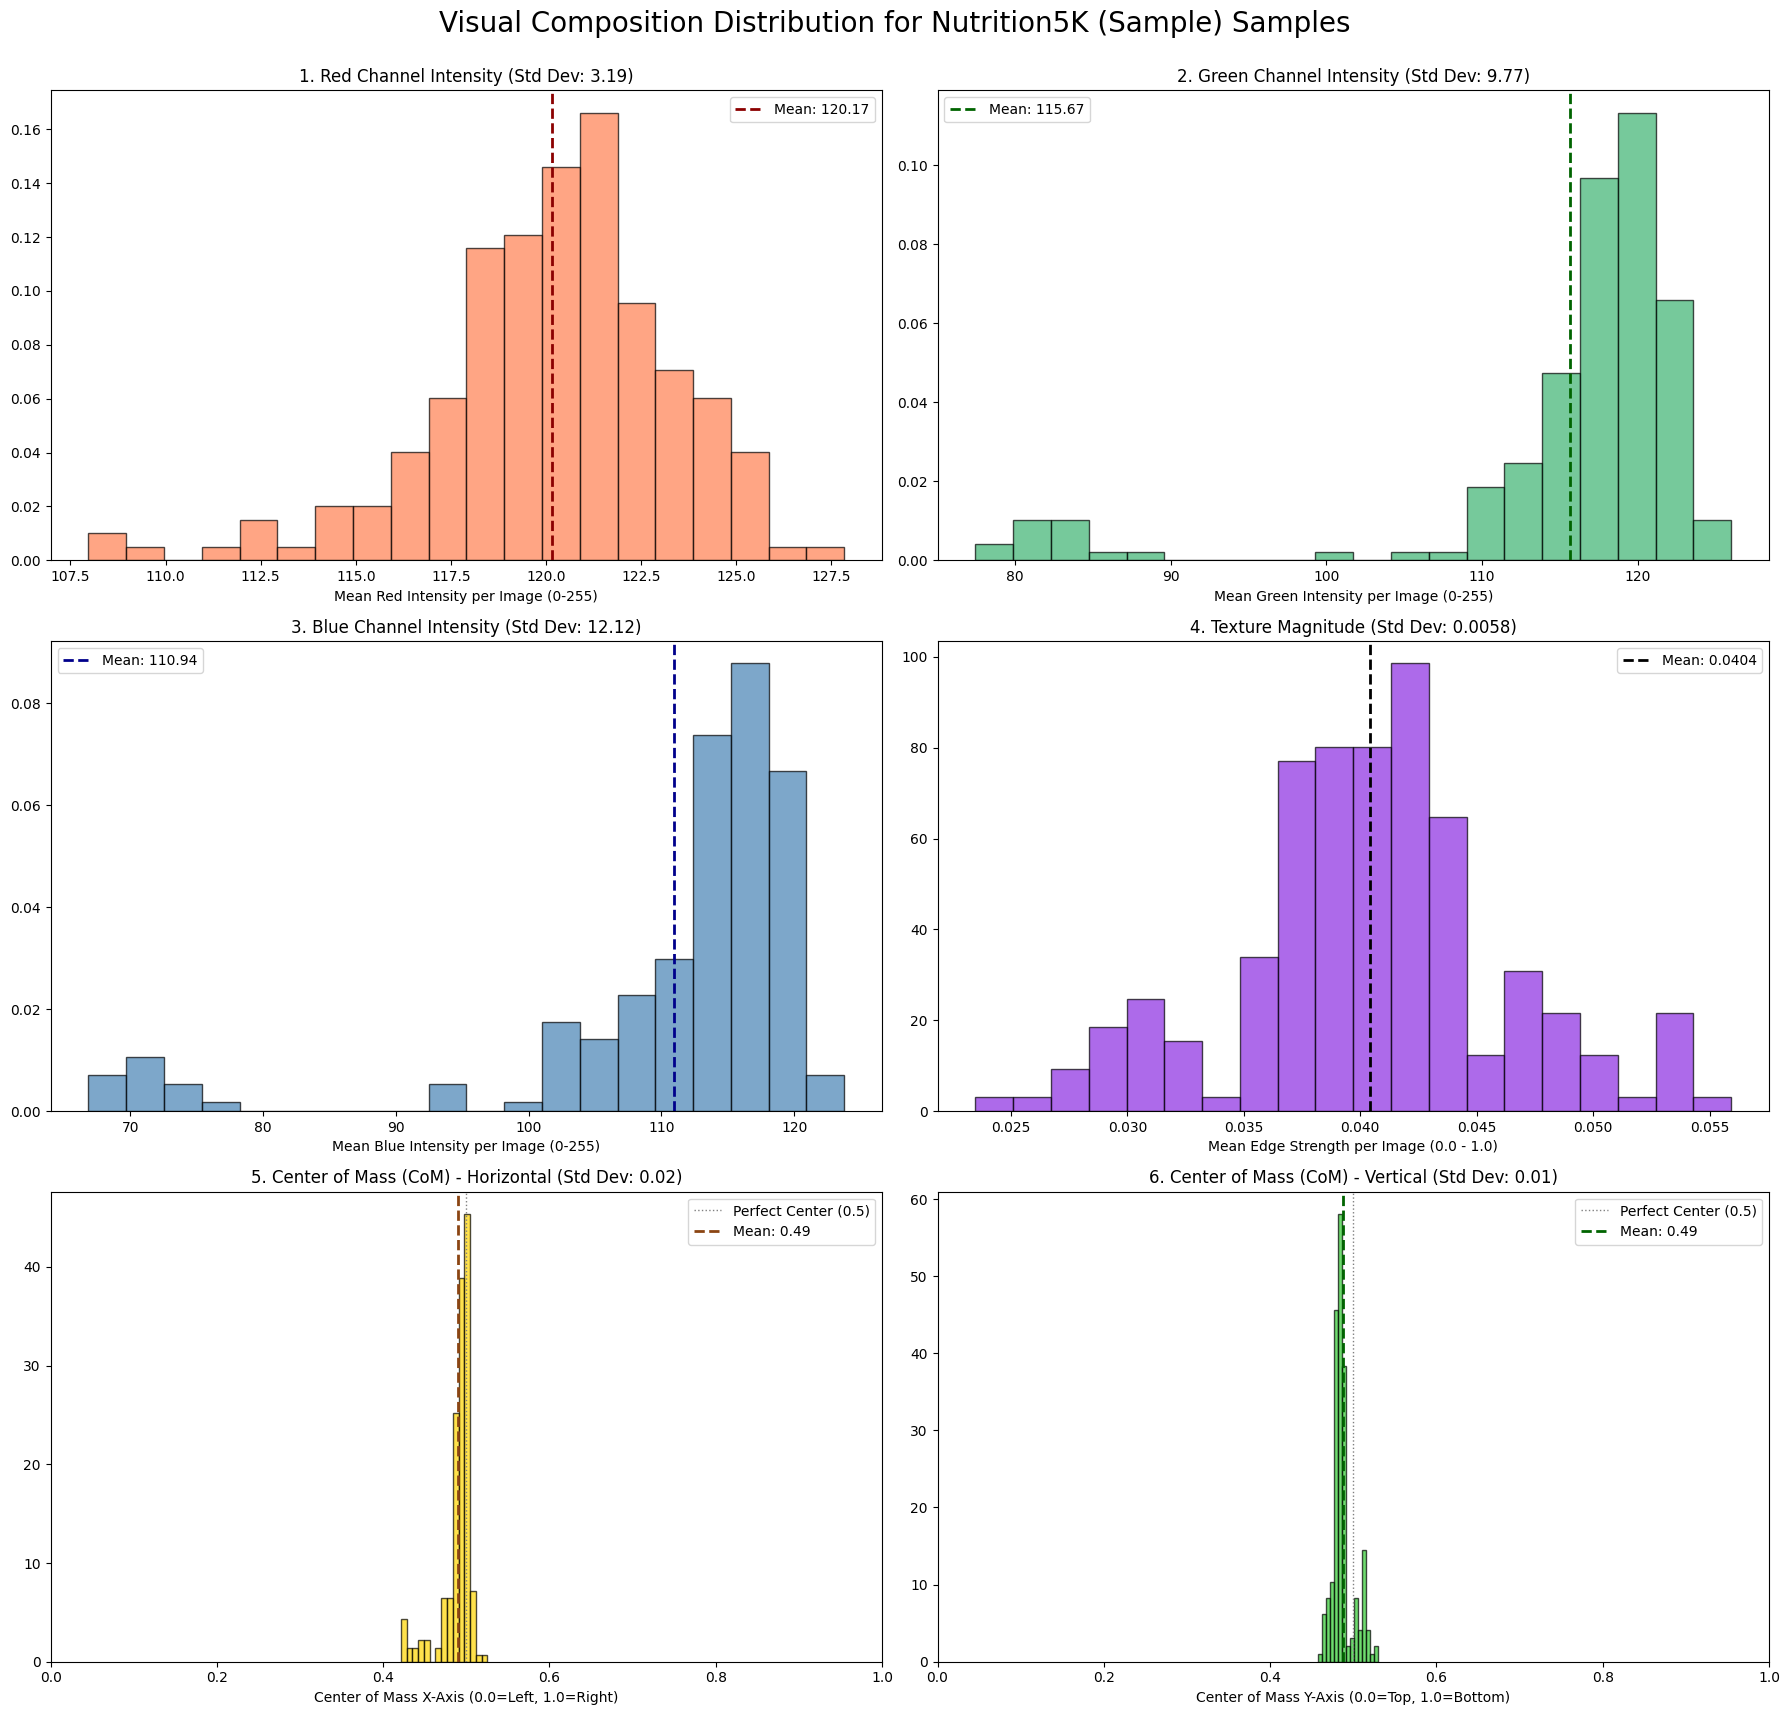

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage.io import imread # Used for loading image files
from skimage.transform import resize
from skimage.filters import sobel # Used for calculating image gradients (texture)
from scipy.ndimage import center_of_mass # Used for calculating spatial center

# --- Configuration ---
# 1. Nutrition5K Sample Dataset (The only dataset being analyzed)
N5K_SAMPLE_DIR = './rgb_samples_fixed/' # Directory where your N5K sample images were downloaded
N5K_NAME = 'Nutrition5K (Sample)'
TARGET_SIZE = (224, 224, 3) # Standard size for image analysis (H, W, C)

# --- 1. Data Loading Function ---

def load_local_nutrition5k_samples():
    """Loads local N5K sample images from the fixed directory."""
    images = []

    # Check if the directory exists
    if not os.path.exists(N5K_SAMPLE_DIR):
        print(f"Error: N5K sample directory not found at {N5K_SAMPLE_DIR}")
        return np.array([])

    print(f"Loading images from {N5K_SAMPLE_DIR}...")

    # Iterate through all files in the directory
    for filename in os.listdir(N5K_SAMPLE_DIR):
        if filename.endswith(".png"): # Assuming the samples are .png
            filepath = os.path.join(N5K_SAMPLE_DIR, filename)
            try:
                # Load image (skimage.io.imread handles different formats and returns np array)
                img = imread(filepath)
                # Resize the image to match a standard size (essential for analysis)
                img_resized = resize(img, TARGET_SIZE, anti_aliasing=True, preserve_range=True)

                # Ensure the image has 3 color channels (e.g., handles 4-channel PNGs or grayscale conversion)
                if img_resized.ndim == 3 and img_resized.shape[-1] == 4: # Handle PNGs with alpha channel
                     img_resized = img_resized[:, :, :3]
                elif img_resized.ndim == 2: # Handle grayscale images (1 channel)
                    # Stack the single channel 3 times to create an RGB image
                    img_resized = np.stack([img_resized, img_resized, img_resized], axis=-1)

                # Ensure the final output is uint8 (0-255 range)
                images.append(img_resized.astype(np.uint8))
            except Exception as e:
                print(f"Could not load or process image {filename}: {e}")

    return np.array(images)


# --- 2. Analysis Functions ---

def calculate_mean_texture(image_array):
    """Calculates the average texture magnitude across the entire dataset (for summary)."""
    if image_array.size == 0:
        return 0.0

    # Normalize pixel values to 0-1 range
    image_array = image_array.astype(np.float32) / 255.0

    # Calculate Sobel edges for all images in the array
    texture_mags = []
    for img in image_array:
        img_gray = np.mean(img, axis=2) # Convert to grayscale
        edges = sobel(img_gray) # Calculate edge magnitude
        texture_mags.append(np.mean(edges)) # Store average edge strength

    return np.mean(texture_mags)


def calculate_all_per_image_metrics(image_array):
    """
    Calculates the mean R, G, B, Texture, and Center of Mass for *each individual image*
    to build the distribution plot data.
    """
    if image_array.size == 0:
        return {'R': [], 'G': [], 'B': [], 'Texture': [], 'CoM_X': [], 'CoM_Y': []}

    N = image_array.shape[0]
    R, G, B, Texture, CoM_X, CoM_Y = [], [], [], [], [], []

    # Iterate over each image
    for i in range(N):
        # Normalize to 0-1 float range
        img = image_array[i].astype(np.float32) / 255.0

        # 1. COLOR (R, G, B)
        mean_rgb = np.mean(img, axis=(0, 1)) * 255
        R.append(mean_rgb[0])
        G.append(mean_rgb[1])
        B.append(mean_rgb[2])

        # 2. TEXTURE (Edge Strength)
        img_gray = np.mean(img, axis=2) # Convert to grayscale
        edges = sobel(img_gray) # Calculate edge magnitude
        Texture.append(np.mean(edges)) # Store average edge strength

        # 3. SPATIAL ARRANGEMENT (Center of Mass - CoM)
        # We use the grayscale image (intensity) as the "mass" map
        # CoM returns (Y_index, X_index)
        com_y, com_x = center_of_mass(img_gray)

        # Normalize CoM coordinates to range from 0.0 (left/top) to 1.0 (right/bottom)
        normalized_com_x = com_x / img.shape[1]
        normalized_com_y = com_y / img.shape[0]

        CoM_X.append(normalized_com_x)
        CoM_Y.append(normalized_com_y)

    return {'R': R, 'G': G, 'B': B, 'Texture': Texture, 'CoM_X': CoM_X, 'CoM_Y': CoM_Y}


# --- 3. Visualization Function (Distribution Plots) ---

def visualize_distribution_plots(metrics_data):
    """Generates histograms showing the distribution of all 5 visual features."""

    # Data extraction
    R_data = metrics_data['R']
    G_data = metrics_data['G']
    B_data = metrics_data['B']
    Texture_data = metrics_data['Texture']
    CoM_X_data = metrics_data['CoM_X']
    CoM_Y_data = metrics_data['CoM_Y']

    # 3 rows and 2 columns for six separate plots
    fig, axes = plt.subplots(3, 2, figsize=(18, 18))
    fig.suptitle(f'Visual Composition Distribution for {N5K_NAME} Samples', fontsize=20)

    # Flatten the axes array for easier indexing: ax[0] to ax[5]
    ax = axes.flatten()

    # --- Plot 1: Red Channel Distribution (Color Warmth) ---
    ax[0].hist(R_data, bins=20, density=True, color='#FF7F50', alpha=0.7, edgecolor='black')
    mean_r = np.mean(R_data); std_r = np.std(R_data)
    ax[0].axvline(mean_r, color='darkred', linestyle='dashed', linewidth=2, label=f'Mean: {mean_r:.2f}')
    ax[0].set_xlabel('Mean Red Intensity per Image (0-255)')
    ax[0].set_title(f'1. Red Channel Intensity (Std Dev: {std_r:.2f})')
    ax[0].legend()

    # --- Plot 2: Green Channel Distribution (Freshness/Saturation) ---
    ax[1].hist(G_data, bins=20, density=True, color='#3CB371', alpha=0.7, edgecolor='black')
    mean_g = np.mean(G_data); std_g = np.std(G_data)
    ax[1].axvline(mean_g, color='darkgreen', linestyle='dashed', linewidth=2, label=f'Mean: {mean_g:.2f}')
    ax[1].set_xlabel('Mean Green Intensity per Image (0-255)')
    ax[1].set_title(f'2. Green Channel Intensity (Std Dev: {std_g:.2f})')
    ax[1].legend()

    # --- Plot 3: Blue Channel Distribution (Coolness/Background) ---
    ax[2].hist(B_data, bins=20, density=True, color='#4682B4', alpha=0.7, edgecolor='black')
    mean_b = np.mean(B_data); std_b = np.std(B_data)
    ax[2].axvline(mean_b, color='darkblue', linestyle='dashed', linewidth=2, label=f'Mean: {mean_b:.2f}')
    ax[2].set_xlabel('Mean Blue Intensity per Image (0-255)')
    ax[2].set_title(f'3. Blue Channel Intensity (Std Dev: {std_b:.2f})')
    ax[2].legend()

    # --- Plot 4: Texture Distribution (Complexity) ---
    ax[3].hist(Texture_data, bins=20, density=True, color='#8A2BE2', alpha=0.7, edgecolor='black')
    mean_t = np.mean(Texture_data); std_t = np.std(Texture_data)
    ax[3].axvline(mean_t, color='black', linestyle='dashed', linewidth=2, label=f'Mean: {mean_t:.4f}')
    ax[3].set_xlabel('Mean Edge Strength per Image (0.0 - 1.0)')
    ax[3].set_title(f'4. Texture Magnitude (Std Dev: {std_t:.4f})')
    ax[3].legend()

    # --- Plot 5: Spatial Arrangement - CoM X (Horizontal Plating) ---
    ax[4].hist(CoM_X_data, bins=15, density=True, color='#FFD700', alpha=0.7, edgecolor='black')
    mean_x = np.mean(CoM_X_data); std_x = np.std(CoM_X_data)
    ax[4].axvline(0.5, color='gray', linestyle='dotted', linewidth=1, label='Perfect Center (0.5)')
    ax[4].axvline(mean_x, color='saddlebrown', linestyle='dashed', linewidth=2, label=f'Mean: {mean_x:.2f}')
    ax[4].set_xlabel('Center of Mass X-Axis (0.0=Left, 1.0=Right)')
    ax[4].set_title(f'5. Center of Mass (CoM) - Horizontal (Std Dev: {std_x:.2f})')
    ax[4].legend()
    ax[4].set_xlim(0.0, 1.0) # Ensure scale is 0 to 1 for normalized coords

    # --- Plot 6: Spatial Arrangement - CoM Y (Vertical Plating) ---
    ax[5].hist(CoM_Y_data, bins=15, density=True, color='#32CD32', alpha=0.7, edgecolor='black')
    mean_y = np.mean(CoM_Y_data); std_y = np.std(CoM_Y_data)
    ax[5].axvline(0.5, color='gray', linestyle='dotted', linewidth=1, label='Perfect Center (0.5)')
    ax[5].axvline(mean_y, color='darkgreen', linestyle='dashed', linewidth=2, label=f'Mean: {mean_y:.2f}')
    ax[5].set_xlabel('Center of Mass Y-Axis (0.0=Top, 1.0=Bottom)')
    ax[5].set_title(f'6. Center of Mass (CoM) - Vertical (Std Dev: {std_y:.2f})')
    ax[5].legend()
    ax[5].set_xlim(0.0, 1.0) # Ensure scale is 0 to 1 for normalized coords

    fig.tight_layout(rect=[0, 0.03, 1, 0.98]) # Adjust layout
    plt.show()


# --- Main Execution ---

print("--- Starting Nutrition5K Visual Composition Analysis ---")

# 1. Load Nutrition5k Sample Data
n5k_samples = load_local_nutrition5k_samples()
if n5k_samples.size == 0:
    print("Cannot proceed with N5K sample data. Check your sample folder.")
    exit()

print(f"N5K Samples Loaded: {n5k_samples.shape[0]} images.")

# 2. Calculate ALL Per-Image Metrics for Distribution Plots
all_metrics = calculate_all_per_image_metrics(n5k_samples)
print("Calculated per-image metrics for R, G, B, Texture, and CoM.")

# 3. Calculate Mean Texture (for simple summary)
n5k_mean_texture_summary = calculate_mean_texture(n5k_samples)

print("\n--- Summary of Dataset Averages ---")
# Calculate mean RGB for quick print
mean_r_summary = np.mean(all_metrics['R'])
mean_g_summary = np.mean(all_metrics['G'])
mean_b_summary = np.mean(all_metrics['B'])

print(f"Mean R/G/B Signature: R={mean_r_summary:.2f}, G={mean_g_summary:.2f}, B={mean_b_summary:.2f}")
print(f"Mean Texture (0-1): {n5k_mean_texture_summary:.4f}")
print(f"Mean CoM (X/Y): X={np.mean(all_metrics['CoM_X']):.2f}, Y={np.mean(all_metrics['CoM_Y']):.2f}")


# 4. Visualize Distribution
print("\nDisplaying Distribution Plots (Histograms/Bell Curve)...")
visualize_distribution_plots(all_metrics)

--- Starting Saudi Cuisine Dataset EDA Analysis ---
Step 1: Loading metadata...
Step 2: Extracting images...
Images already extracted to ./extracted_saudi_images/
Saudi Metadata Loaded: 278 records

Step 3: Analyzing dish distribution...


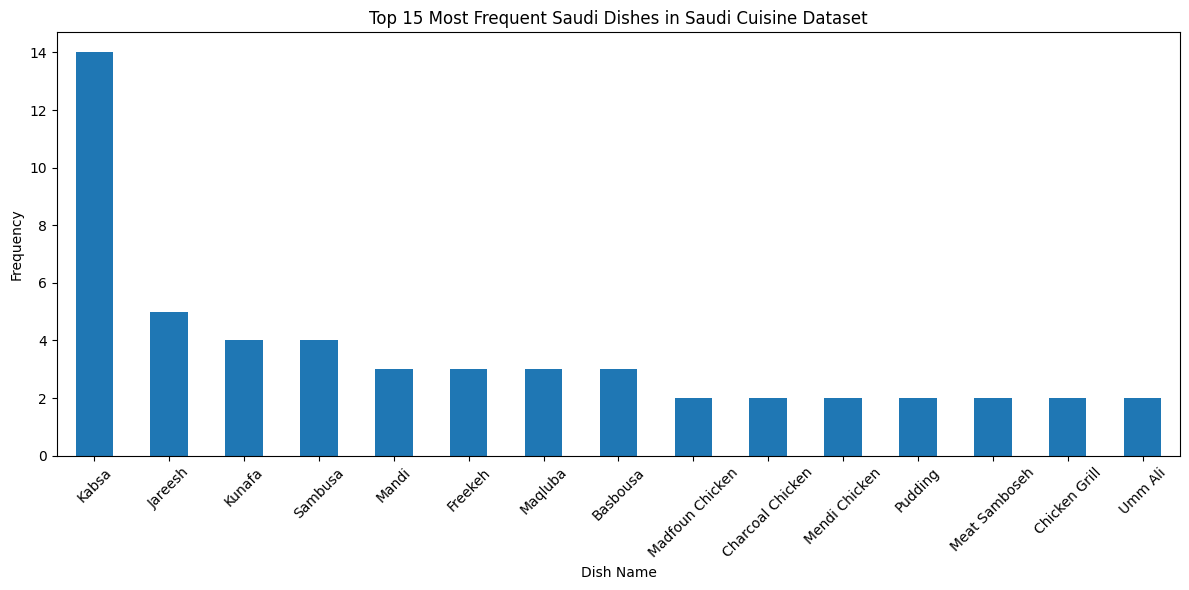

Step 4: Analyzing ingredient patterns...


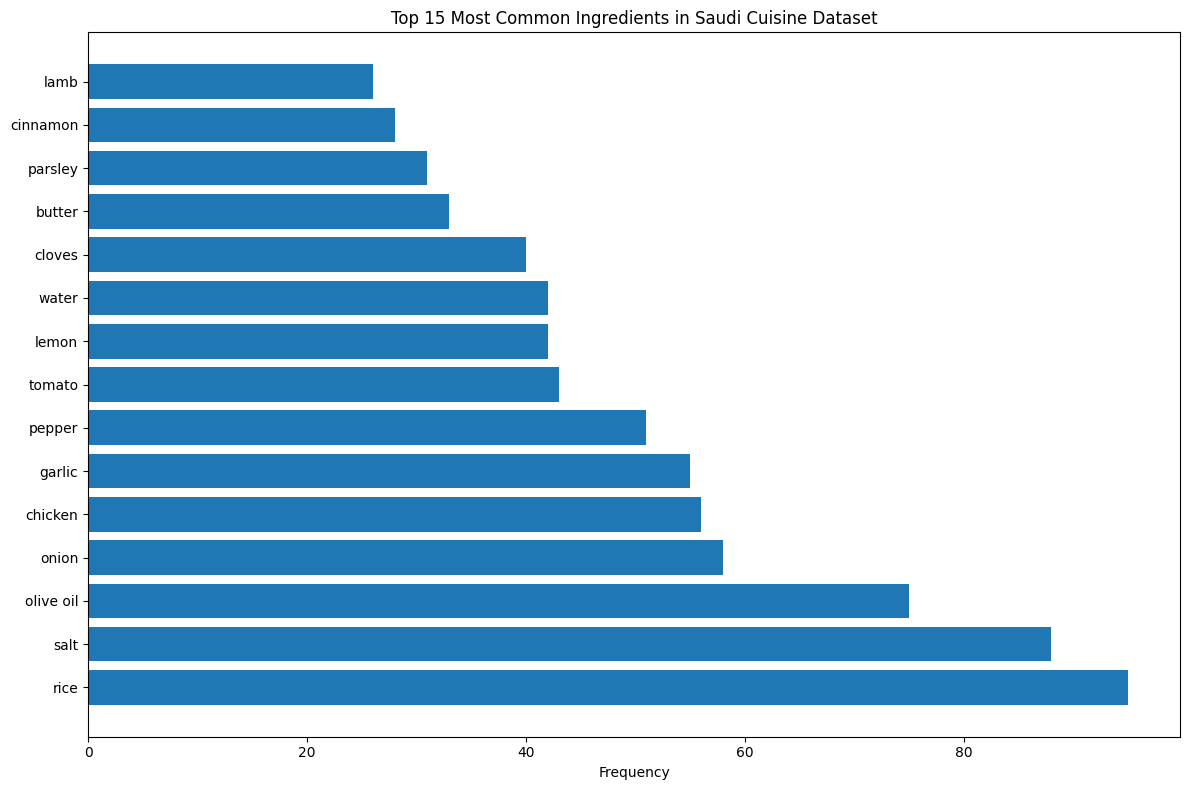

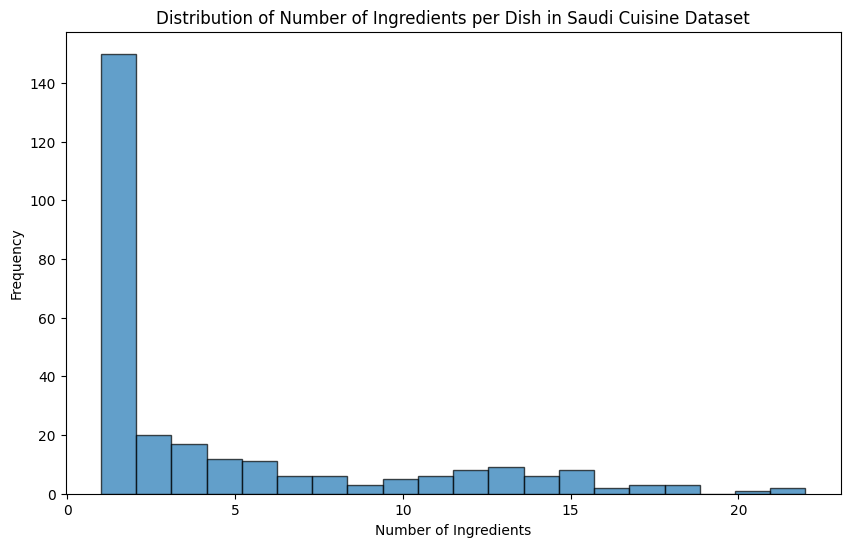

Step 6: Analyzing dish complexity...


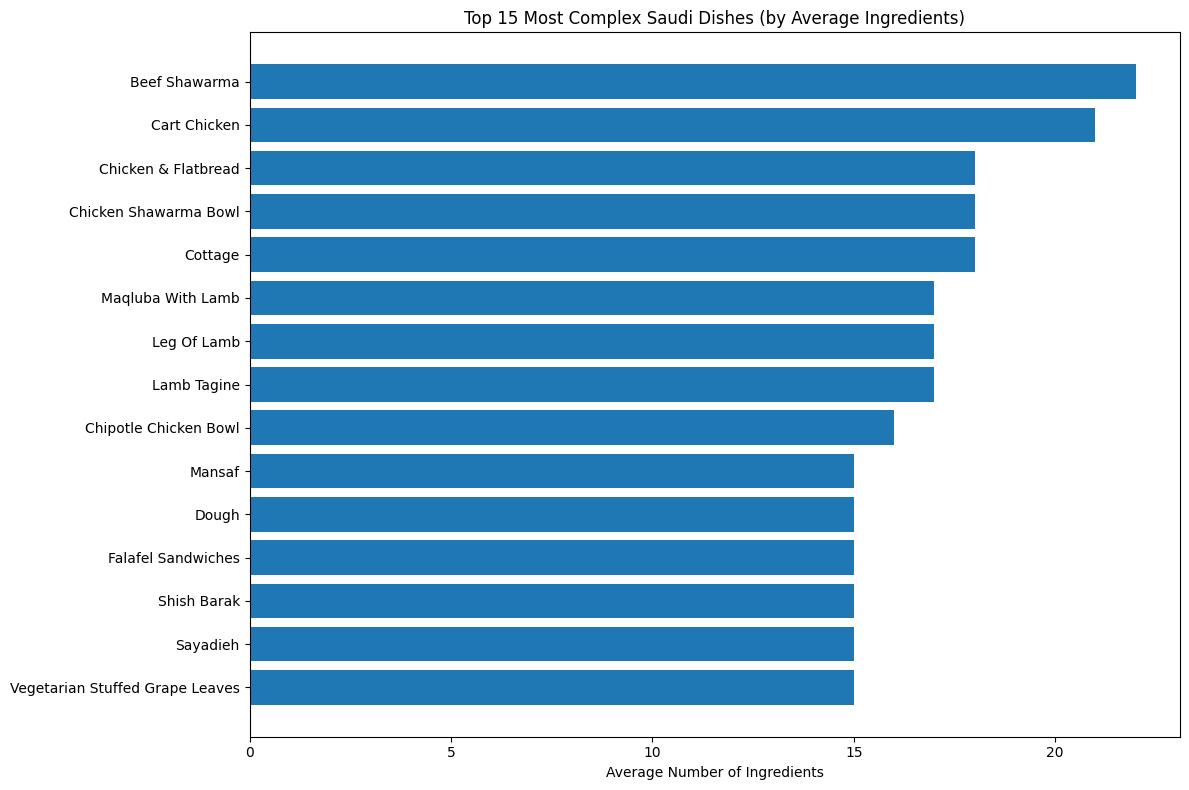

Step 7: Analyzing ingredient co-occurrence...


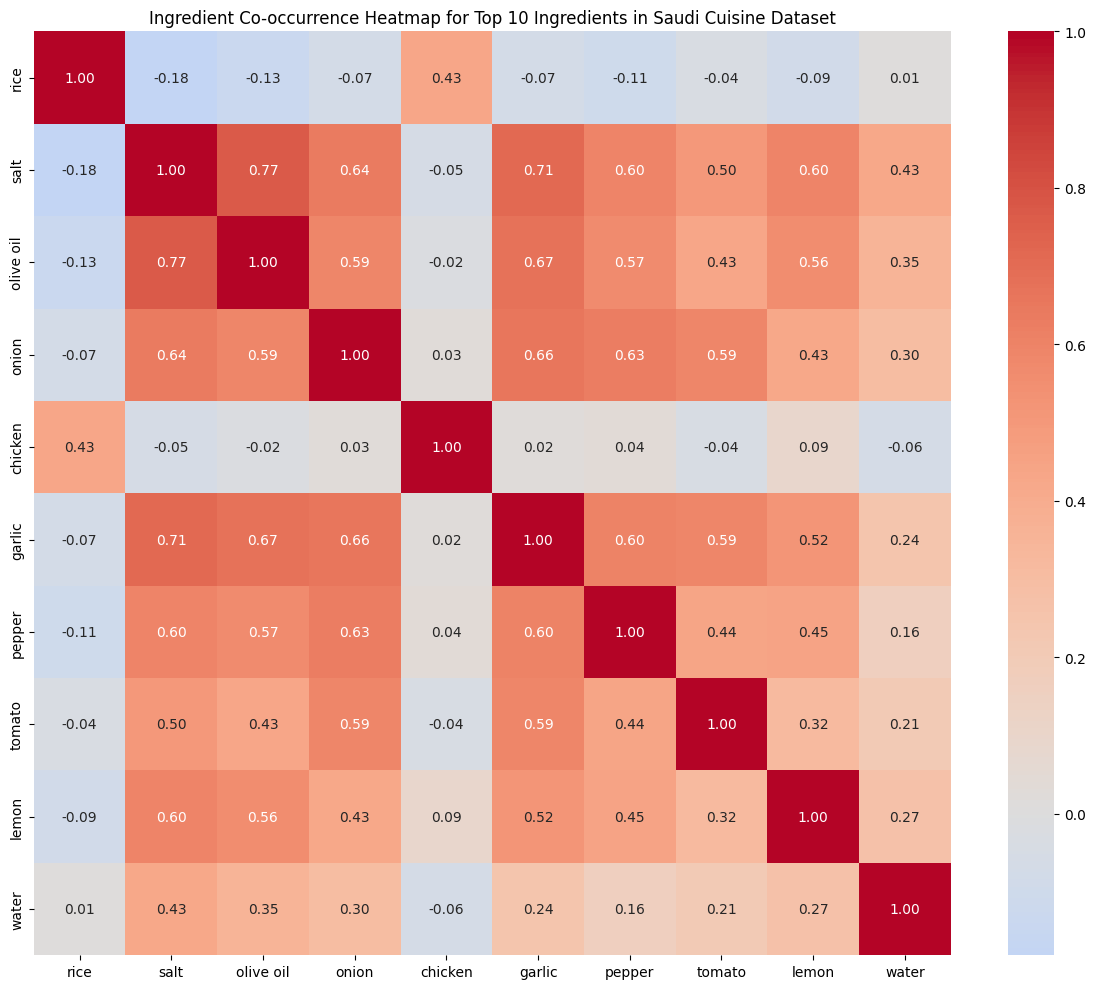


SAUDI CUISINE DATASET EDA SUMMARY
Total Records: 278
Unique Dishes: 228
Unique Ingredients: 104
Average Ingredients per Dish: 4.78 ± 4.90
Data Collection Period: 2025-09-30 to 2025-09-30
Collection Duration: 0 days
Most Common Dish: 'Kabsa' (14 occurrences)
Most Common Ingredient: 'rice' (95 occurrences)
Dishes with Most Ingredients: 22 ingredients
Dishes with Least Ingredients: 1 ingredients

Data Quality Metrics:
  - Records with missing image paths: 0 (0.0%)
  - Records with no ingredients: 0 (0.0%)

--- Saudi Cuisine EDA Analysis Complete ---


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import ast
from collections import Counter
import zipfile
from datetime import datetime
import seaborn as sns
from skimage.io import imread
from skimage.transform import resize
from skimage.filters import sobel
from scipy.ndimage import center_of_mass

# --- Configuration ---
# Saudi Cuisine Dataset
SAUDI_CSV_PATH = 'SaudiFoodFile_standardized_consistentM.csv'  # Update with your CSV path
SAUDI_IMAGE_ZIP = 'renamed_images-2.zip'
SAUDI_EXTRACT_DIR = './extracted_saudi_images/'
SAUDI_NAME = 'Saudi Cuisine Dataset'

# --- 1. Data Loading Functions for Saudi Dataset ---

def load_saudi_metadata():
    """Loads and processes the Saudi cuisine metadata from CSV."""
    df = pd.read_csv(SAUDI_CSV_PATH)

    # Process ingredients from classifications_std_list
    def extract_ingredients(ingredient_list):
        try:
            if isinstance(ingredient_list, str):
                return ast.literal_eval(ingredient_list)
            return ingredient_list
        except:
            return []

    df['ingredients_list'] = df['classifications_std_list'].apply(extract_ingredients)
    df['num_ingredients'] = df['ingredients_list'].apply(len)
    df['scrape_date'] = pd.to_datetime(df['scrape_date'])

    return df

def extract_saudi_images():
    """Extracts Saudi cuisine images from ZIP file."""
    if not os.path.exists(SAUDI_IMAGE_ZIP):
        print(f"Error: ZIP file {SAUDI_IMAGE_ZIP} not found!")
        return False

    os.makedirs(SAUDI_EXTRACT_DIR, exist_ok=True)

    if os.listdir(SAUDI_EXTRACT_DIR):
        print(f"Images already extracted to {SAUDI_EXTRACT_DIR}")
        return True

    print(f"Extracting {SAUDI_IMAGE_ZIP} to {SAUDI_EXTRACT_DIR}...")
    try:
        with zipfile.ZipFile(SAUDI_IMAGE_ZIP, 'r') as zip_ref:
            zip_ref.extractall(SAUDI_EXTRACT_DIR)
        print("Extraction completed successfully!")
        return True
    except Exception as e:
        print(f"Error extracting ZIP file: {e}")
        return False

# --- 2. Saudi-Specific Analysis Functions ---

def analyze_dish_distribution(df):
    """Analyzes the distribution of dish names."""
    dish_counts = df['dish_name'].value_counts()

    plt.figure(figsize=(12, 6))
    dish_counts.head(15).plot(kind='bar')
    plt.title(f'Top 15 Most Frequent Saudi Dishes in {SAUDI_NAME}')
    plt.xlabel('Dish Name')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return dish_counts

def analyze_ingredient_patterns(df):
    """Analyzes ingredient distribution and patterns."""
    all_ingredients = []
    for ingredients in df['ingredients_list']:
        all_ingredients.extend(ingredients)

    ingredient_counts = Counter(all_ingredients)

    # Plot top ingredients
    plt.figure(figsize=(12, 8))
    top_ingredients = dict(ingredient_counts.most_common(15))
    plt.barh(list(top_ingredients.keys()), list(top_ingredients.values()))
    plt.title(f'Top 15 Most Common Ingredients in {SAUDI_NAME}')
    plt.xlabel('Frequency')
    plt.tight_layout()
    plt.show()

    # Plot ingredients per dish distribution
    plt.figure(figsize=(10, 6))
    plt.hist(df['num_ingredients'], bins=20, edgecolor='black', alpha=0.7)
    plt.title(f'Distribution of Number of Ingredients per Dish in {SAUDI_NAME}')
    plt.xlabel('Number of Ingredients')
    plt.ylabel('Frequency')
    plt.show()

    return ingredient_counts


def analyze_dish_complexity(df):
    """Analyzes ingredient complexity by dish."""
    dish_complexity = df.groupby('dish_name')['num_ingredients'].agg(['mean', 'count']).sort_values('mean', ascending=False)

    # Plot most complex dishes
    plt.figure(figsize=(12, 8))
    top_complex = dish_complexity.head(15)
    plt.barh(range(len(top_complex)), top_complex['mean'])
    plt.yticks(range(len(top_complex)), top_complex.index)
    plt.title(f'Top 15 Most Complex Saudi Dishes (by Average Ingredients)')
    plt.xlabel('Average Number of Ingredients')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    return dish_complexity

def visualize_ingredient_co_occurrence(df, top_n=10):
    """Visualizes ingredient co-occurrence patterns."""
    from sklearn.preprocessing import MultiLabelBinarizer

    mlb = MultiLabelBinarizer()
    ingredient_matrix = mlb.fit_transform(df['ingredients_list'])
    ingredient_df = pd.DataFrame(ingredient_matrix, columns=mlb.classes_)

    # Get top ingredients
    all_ingredients = []
    for ingredients in df['ingredients_list']:
        all_ingredients.extend(ingredients)
    top_ingredients = [ing[0] for ing in Counter(all_ingredients).most_common(top_n)]

    # Calculate correlation for top ingredients
    co_occurrence = ingredient_df[top_ingredients].corr()

    plt.figure(figsize=(12, 10))
    sns.heatmap(co_occurrence, annot=True, cmap='coolwarm', center=0, fmt='.2f')
    plt.title(f'Ingredient Co-occurrence Heatmap for Top {top_n} Ingredients in {SAUDI_NAME}')
    plt.tight_layout()
    plt.show()

    return co_occurrence

# --- 3. Summary Statistics Function ---

def print_saudi_summary(df, ingredient_counts, dish_counts, date_counts):
    """Prints comprehensive summary of Saudi dataset."""
    print("\n" + "="*60)
    print(f"SAUDI CUISINE DATASET EDA SUMMARY")
    print("="*60)
    print(f"Total Records: {df.shape[0]:,}")
    print(f"Unique Dishes: {df['dish_name'].nunique()}")
    print(f"Unique Ingredients: {len(ingredient_counts)}")
    print(f"Average Ingredients per Dish: {df['num_ingredients'].mean():.2f} ± {df['num_ingredients'].std():.2f}")
    print(f"Data Collection Period: {df['scrape_date'].min().date()} to {df['scrape_date'].max().date()}")
    print(f"Collection Duration: {(df['scrape_date'].max() - df['scrape_date'].min()).days} days")
    print(f"Most Common Dish: '{dish_counts.index[0]}' ({dish_counts.iloc[0]} occurrences)")
    print(f"Most Common Ingredient: '{ingredient_counts.most_common(1)[0][0]}' ({ingredient_counts.most_common(1)[0][1]} occurrences)")
    print(f"Dishes with Most Ingredients: {df['num_ingredients'].max()} ingredients")
    print(f"Dishes with Least Ingredients: {df['num_ingredients'].min()} ingredients")

    # Data quality checks
    missing_images = df['image_file'].isna().sum()
    empty_ingredients = (df['num_ingredients'] == 0).sum()
    print(f"\nData Quality Metrics:")
    print(f"  - Records with missing image paths: {missing_images} ({missing_images/df.shape[0]*100:.1f}%)")
    print(f"  - Records with no ingredients: {empty_ingredients} ({empty_ingredients/df.shape[0]*100:.1f}%)")

# --- Main Execution for Saudi Dataset ---

print("--- Starting Saudi Cuisine Dataset EDA Analysis ---")

# 1. Load and extract data
print("Step 1: Loading metadata...")
df = load_saudi_metadata()

print("Step 2: Extracting images...")
extract_saudi_images()

print(f"Saudi Metadata Loaded: {df.shape[0]} records")

# 2. Perform analyses
print("\nStep 3: Analyzing dish distribution...")
dish_counts = analyze_dish_distribution(df)

print("Step 4: Analyzing ingredient patterns...")
ingredient_counts = analyze_ingredient_patterns(df)


print("Step 6: Analyzing dish complexity...")
dish_complexity = analyze_dish_complexity(df)

print("Step 7: Analyzing ingredient co-occurrence...")
co_occurrence = visualize_ingredient_co_occurrence(df)

# 3. Print comprehensive summary
print_saudi_summary(df, ingredient_counts, dish_counts, date_counts)

print("\n--- Saudi Cuisine EDA Analysis Complete ---")

--- Starting Saudi Cuisine Visual Composition Analysis ---
Images already extracted to ./extracted_saudi_images/
Loading Saudi cuisine images from ./extracted_saudi_images/...
Successfully loaded 278 images
Saudi Samples Loaded: 278 images.
Calculated per-image metrics for R, G, B, Texture, and CoM.

--- Summary of Saudi Dataset Averages ---
Mean R/G/B Signature: R=179.16, G=151.32, B=129.04
Mean Texture (0-1): 0.0478
Mean CoM (X/Y): X=0.50, Y=0.50

Displaying Distribution Plots (Histograms/Bell Curve)...


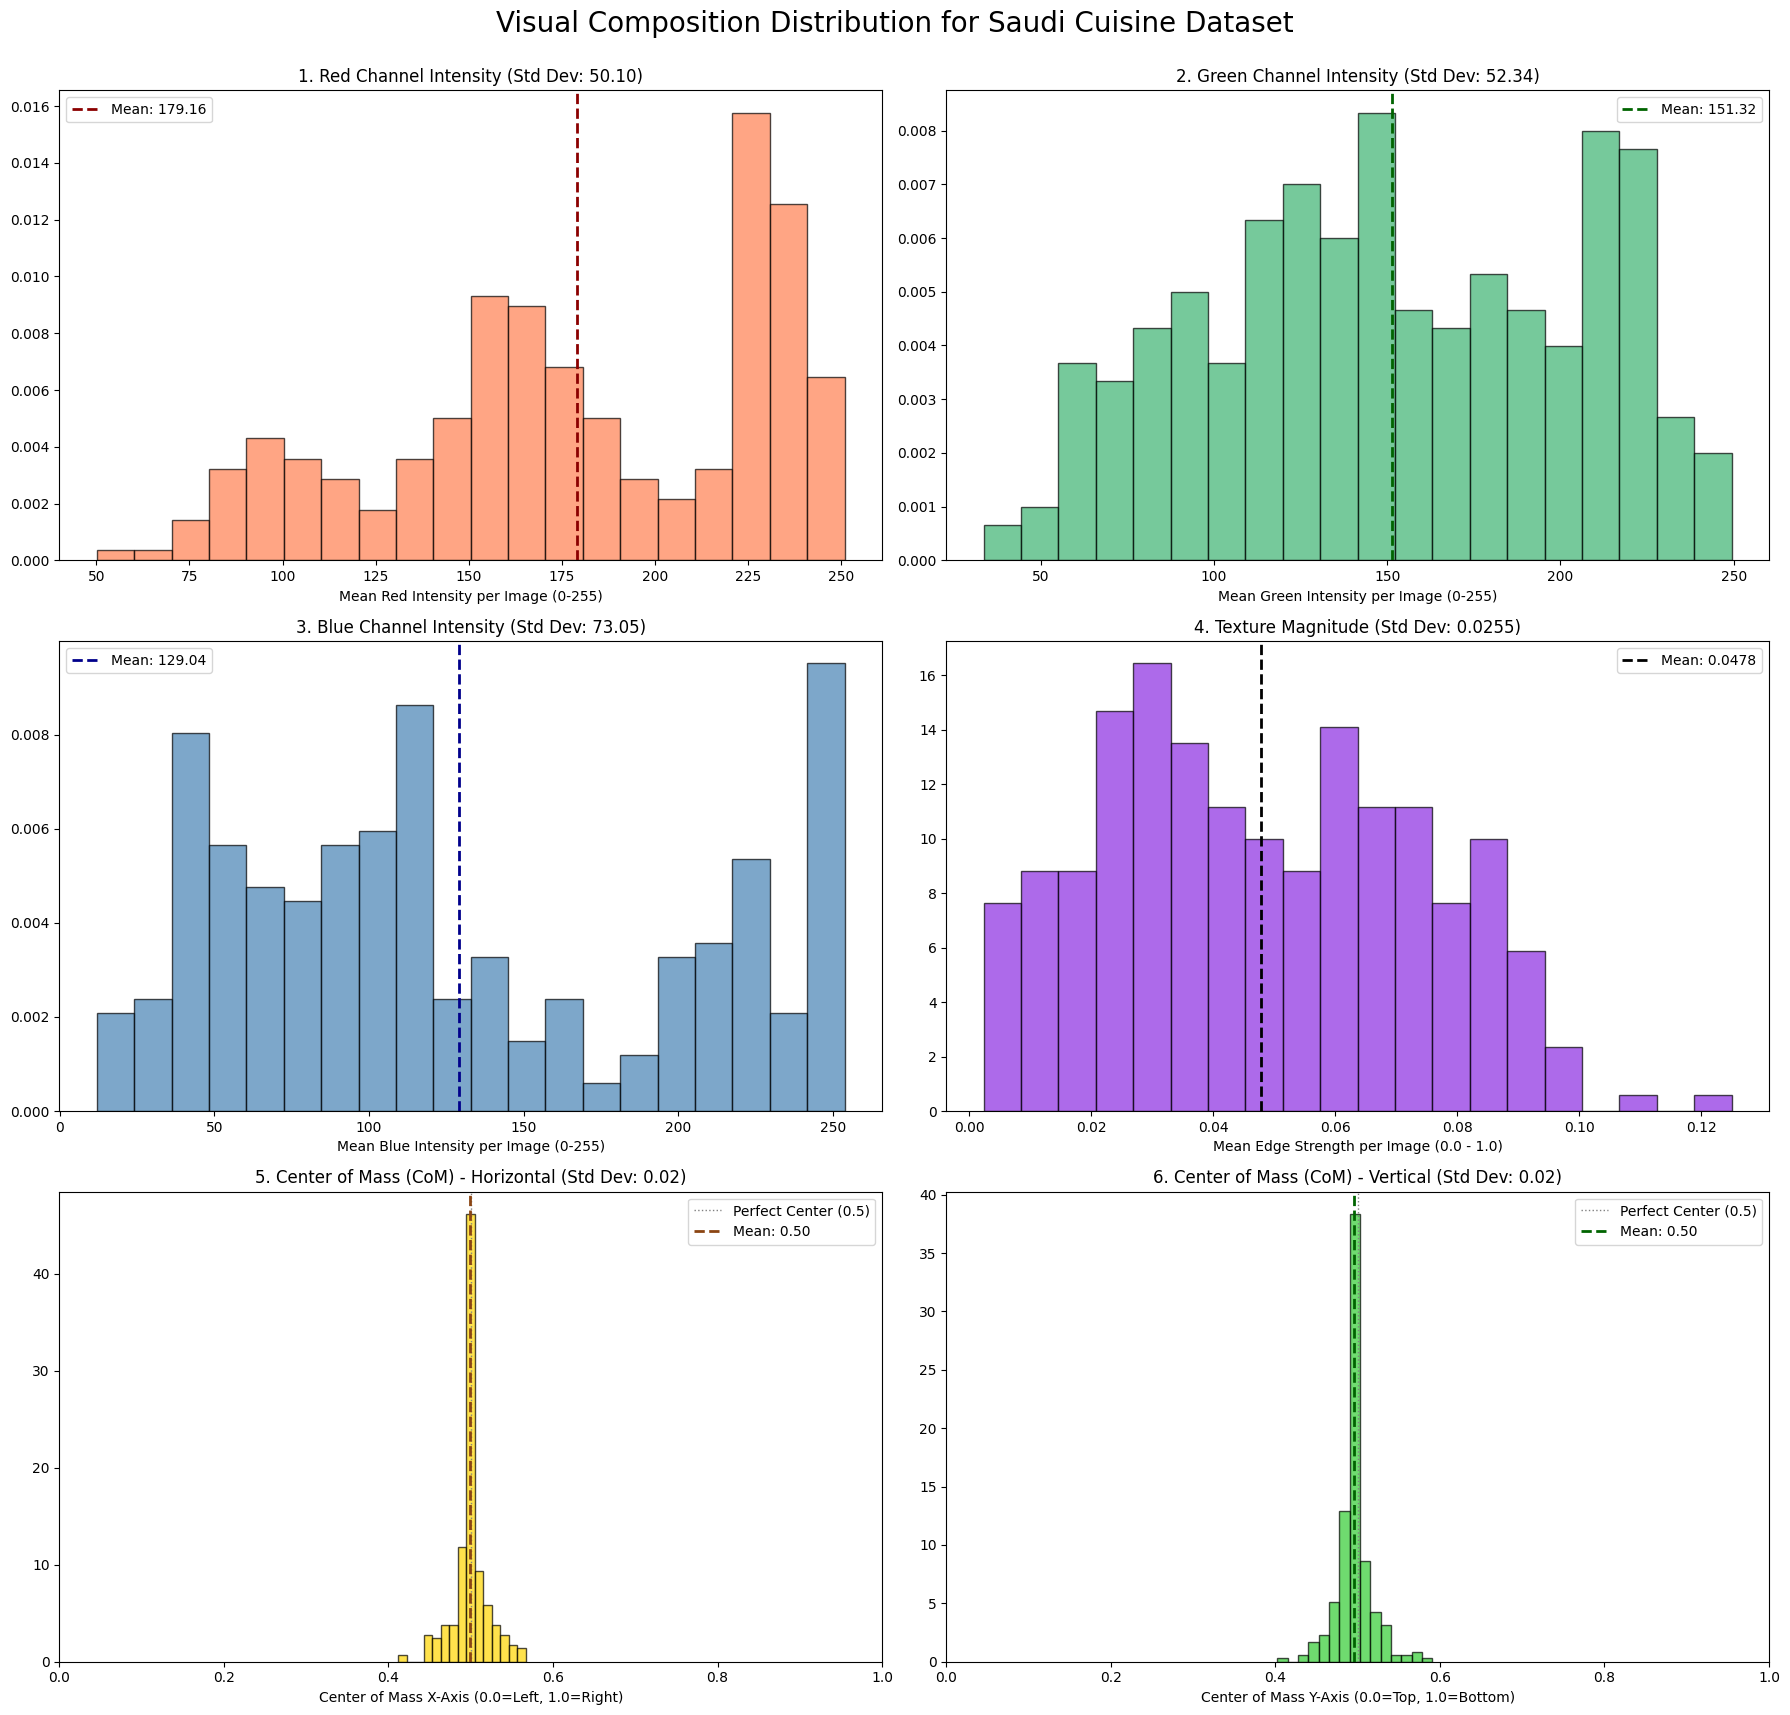


--- Saudi Cuisine Visual Analysis Complete ---


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from skimage.io import imread
from skimage.transform import resize
from skimage.filters import sobel
from scipy.ndimage import center_of_mass
import zipfile
import ast

# --- Configuration ---
# Saudi Cuisine Dataset
SAUDI_CSV_PATH = 'SaudiFoodFile_standardized_consistentM.csv'  # Update with your CSV path
SAUDI_IMAGE_ZIP = 'renamed_images-2.zip'
SAUDI_EXTRACT_DIR = './extracted_saudi_images/'
SAUDI_NAME = 'Saudi Cuisine Dataset'
TARGET_SIZE = (224, 224, 3)  # Same size as N5K analysis

# --- 1. Data Loading Functions ---

def extract_saudi_images():
    """Extracts Saudi cuisine images from ZIP file."""
    if not os.path.exists(SAUDI_IMAGE_ZIP):
        print(f"Error: ZIP file {SAUDI_IMAGE_ZIP} not found!")
        return False

    os.makedirs(SAUDI_EXTRACT_DIR, exist_ok=True)

    if os.listdir(SAUDI_EXTRACT_DIR):
        print(f"Images already extracted to {SAUDI_EXTRACT_DIR}")
        return True

    print(f"Extracting {SAUDI_IMAGE_ZIP} to {SAUDI_EXTRACT_DIR}...")
    try:
        with zipfile.ZipFile(SAUDI_IMAGE_ZIP, 'r') as zip_ref:
            zip_ref.extractall(SAUDI_EXTRACT_DIR)
        print("Extraction completed successfully!")
        return True
    except Exception as e:
        print(f"Error extracting ZIP file: {e}")
        return False

def load_saudi_metadata():
    """Loads and processes the Saudi cuisine metadata from CSV."""
    df = pd.read_csv(SAUDI_CSV_PATH)

    # Process ingredients from classifications_std_list
    def extract_ingredients(ingredient_list):
        try:
            if isinstance(ingredient_list, str):
                return ast.literal_eval(ingredient_list)
            return ingredient_list
        except:
            return []

    df['ingredients_list'] = df['classifications_std_list'].apply(extract_ingredients)
    df['num_ingredients'] = df['ingredients_list'].apply(len)

    return df

def load_saudi_samples():
    """Loads Saudi cuisine images from the extracted directory."""
    # First extract images
    if not extract_saudi_images():
        return np.array([]), pd.DataFrame()

    images = []
    df = load_saudi_metadata()

    print(f"Loading Saudi cuisine images from {SAUDI_EXTRACT_DIR}...")

    # Count successful loads
    loaded_count = 0
    missing_count = 0

    # Iterate through all files in the extracted directory
    for filename in os.listdir(SAUDI_EXTRACT_DIR):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            filepath = os.path.join(SAUDI_EXTRACT_DIR, filename)
            try:
                # Load image
                img = imread(filepath)
                # Resize the image to match standard size
                img_resized = resize(img, TARGET_SIZE, anti_aliasing=True, preserve_range=True)

                # Ensure the image has 3 color channels
                if img_resized.ndim == 3 and img_resized.shape[-1] == 4:
                    img_resized = img_resized[:, :, :3]
                elif img_resized.ndim == 2:
                    img_resized = np.stack([img_resized, img_resized, img_resized], axis=-1)

                # Ensure final output is uint8
                images.append(img_resized.astype(np.uint8))
                loaded_count += 1

            except Exception as e:
                print(f"Could not load or process image {filename}: {e}")
                missing_count += 1

    print(f"Successfully loaded {loaded_count} images")
    if missing_count > 0:
        print(f"Failed to load {missing_count} images")

    return np.array(images), df

# --- 2. Analysis Functions (EXACTLY same as N5K) ---

def calculate_mean_texture(image_array):
    """Calculates the average texture magnitude across the entire dataset (for summary)."""
    if image_array.size == 0:
        return 0.0

    # Normalize pixel values to 0-1 range
    image_array = image_array.astype(np.float32) / 255.0

    # Calculate Sobel edges for all images in the array
    texture_mags = []
    for img in image_array:
        img_gray = np.mean(img, axis=2)  # Convert to grayscale
        edges = sobel(img_gray)  # Calculate edge magnitude
        texture_mags.append(np.mean(edges))  # Store average edge strength

    return np.mean(texture_mags)

def calculate_all_per_image_metrics(image_array):
    """
    Calculates the mean R, G, B, Texture, and Center of Mass for *each individual image*
    to build the distribution plot data.
    """
    if image_array.size == 0:
        return {'R': [], 'G': [], 'B': [], 'Texture': [], 'CoM_X': [], 'CoM_Y': []}

    N = image_array.shape[0]
    R, G, B, Texture, CoM_X, CoM_Y = [], [], [], [], [], []

    # Iterate over each image
    for i in range(N):
        # Normalize to 0-1 float range
        img = image_array[i].astype(np.float32) / 255.0

        # 1. COLOR (R, G, B)
        mean_rgb = np.mean(img, axis=(0, 1)) * 255
        R.append(mean_rgb[0])
        G.append(mean_rgb[1])
        B.append(mean_rgb[2])

        # 2. TEXTURE (Edge Strength)
        img_gray = np.mean(img, axis=2)  # Convert to grayscale
        edges = sobel(img_gray)  # Calculate edge magnitude
        Texture.append(np.mean(edges))  # Store average edge strength

        # 3. SPATIAL ARRANGEMENT (Center of Mass - CoM)
        # We use the grayscale image (intensity) as the "mass" map
        # CoM returns (Y_index, X_index)
        com_y, com_x = center_of_mass(img_gray)

        # Normalize CoM coordinates to range from 0.0 (left/top) to 1.0 (right/bottom)
        normalized_com_x = com_x / img.shape[1]
        normalized_com_y = com_y / img.shape[0]

        CoM_X.append(normalized_com_x)
        CoM_Y.append(normalized_com_y)

    return {'R': R, 'G': G, 'B': B, 'Texture': Texture, 'CoM_X': CoM_X, 'CoM_Y': CoM_Y}

# --- 3. Visualization Function (EXACTLY same as N5K) ---

def visualize_distribution_plots(metrics_data, dataset_name):
    """Generates histograms showing the distribution of all 5 visual features."""

    # Data extraction
    R_data = metrics_data['R']
    G_data = metrics_data['G']
    B_data = metrics_data['B']
    Texture_data = metrics_data['Texture']
    CoM_X_data = metrics_data['CoM_X']
    CoM_Y_data = metrics_data['CoM_Y']

    # 3 rows and 2 columns for six separate plots
    fig, axes = plt.subplots(3, 2, figsize=(18, 18))
    fig.suptitle(f'Visual Composition Distribution for {dataset_name}', fontsize=20)

    # Flatten the axes array for easier indexing: ax[0] to ax[5]
    ax = axes.flatten()

    # --- Plot 1: Red Channel Distribution (Color Warmth) ---
    ax[0].hist(R_data, bins=20, density=True, color='#FF7F50', alpha=0.7, edgecolor='black')
    mean_r = np.mean(R_data); std_r = np.std(R_data)
    ax[0].axvline(mean_r, color='darkred', linestyle='dashed', linewidth=2, label=f'Mean: {mean_r:.2f}')
    ax[0].set_xlabel('Mean Red Intensity per Image (0-255)')
    ax[0].set_title(f'1. Red Channel Intensity (Std Dev: {std_r:.2f})')
    ax[0].legend()

    # --- Plot 2: Green Channel Distribution (Freshness/Saturation) ---
    ax[1].hist(G_data, bins=20, density=True, color='#3CB371', alpha=0.7, edgecolor='black')
    mean_g = np.mean(G_data); std_g = np.std(G_data)
    ax[1].axvline(mean_g, color='darkgreen', linestyle='dashed', linewidth=2, label=f'Mean: {mean_g:.2f}')
    ax[1].set_xlabel('Mean Green Intensity per Image (0-255)')
    ax[1].set_title(f'2. Green Channel Intensity (Std Dev: {std_g:.2f})')
    ax[1].legend()

    # --- Plot 3: Blue Channel Distribution (Coolness/Background) ---
    ax[2].hist(B_data, bins=20, density=True, color='#4682B4', alpha=0.7, edgecolor='black')
    mean_b = np.mean(B_data); std_b = np.std(B_data)
    ax[2].axvline(mean_b, color='darkblue', linestyle='dashed', linewidth=2, label=f'Mean: {mean_b:.2f}')
    ax[2].set_xlabel('Mean Blue Intensity per Image (0-255)')
    ax[2].set_title(f'3. Blue Channel Intensity (Std Dev: {std_b:.2f})')
    ax[2].legend()

    # --- Plot 4: Texture Distribution (Complexity) ---
    ax[3].hist(Texture_data, bins=20, density=True, color='#8A2BE2', alpha=0.7, edgecolor='black')
    mean_t = np.mean(Texture_data); std_t = np.std(Texture_data)
    ax[3].axvline(mean_t, color='black', linestyle='dashed', linewidth=2, label=f'Mean: {mean_t:.4f}')
    ax[3].set_xlabel('Mean Edge Strength per Image (0.0 - 1.0)')
    ax[3].set_title(f'4. Texture Magnitude (Std Dev: {std_t:.4f})')
    ax[3].legend()

    # --- Plot 5: Spatial Arrangement - CoM X (Horizontal Plating) ---
    ax[4].hist(CoM_X_data, bins=15, density=True, color='#FFD700', alpha=0.7, edgecolor='black')
    mean_x = np.mean(CoM_X_data); std_x = np.std(CoM_X_data)
    ax[4].axvline(0.5, color='gray', linestyle='dotted', linewidth=1, label='Perfect Center (0.5)')
    ax[4].axvline(mean_x, color='saddlebrown', linestyle='dashed', linewidth=2, label=f'Mean: {mean_x:.2f}')
    ax[4].set_xlabel('Center of Mass X-Axis (0.0=Left, 1.0=Right)')
    ax[4].set_title(f'5. Center of Mass (CoM) - Horizontal (Std Dev: {std_x:.2f})')
    ax[4].legend()
    ax[4].set_xlim(0.0, 1.0)  # Ensure scale is 0 to 1 for normalized coords

    # --- Plot 6: Spatial Arrangement - CoM Y (Vertical Plating) ---
    ax[5].hist(CoM_Y_data, bins=15, density=True, color='#32CD32', alpha=0.7, edgecolor='black')
    mean_y = np.mean(CoM_Y_data); std_y = np.std(CoM_Y_data)
    ax[5].axvline(0.5, color='gray', linestyle='dotted', linewidth=1, label='Perfect Center (0.5)')
    ax[5].axvline(mean_y, color='darkgreen', linestyle='dashed', linewidth=2, label=f'Mean: {mean_y:.2f}')
    ax[5].set_xlabel('Center of Mass Y-Axis (0.0=Top, 1.0=Bottom)')
    ax[5].set_title(f'6. Center of Mass (CoM) - Vertical (Std Dev: {std_y:.2f})')
    ax[5].legend()
    ax[5].set_xlim(0.0, 1.0)  # Ensure scale is 0 to 1 for normalized coords

    fig.tight_layout(rect=[0, 0.03, 1, 0.98])  # Adjust layout
    plt.show()

# --- Main Execution ---

print("--- Starting Saudi Cuisine Visual Composition Analysis ---")

# 1. Load Saudi Sample Data
saudi_samples, df = load_saudi_samples()
if saudi_samples.size == 0:
    print("Cannot proceed with Saudi sample data. Check your files.")
    exit()

print(f"Saudi Samples Loaded: {saudi_samples.shape[0]} images.")

# 2. Calculate ALL Per-Image Metrics for Distribution Plots
all_metrics = calculate_all_per_image_metrics(saudi_samples)
print("Calculated per-image metrics for R, G, B, Texture, and CoM.")

# 3. Calculate Mean Texture (for simple summary)
saudi_mean_texture_summary = calculate_mean_texture(saudi_samples)

print("\n--- Summary of Saudi Dataset Averages ---")
# Calculate mean RGB for quick print
mean_r_summary = np.mean(all_metrics['R'])
mean_g_summary = np.mean(all_metrics['G'])
mean_b_summary = np.mean(all_metrics['B'])

print(f"Mean R/G/B Signature: R={mean_r_summary:.2f}, G={mean_g_summary:.2f}, B={mean_b_summary:.2f}")
print(f"Mean Texture (0-1): {saudi_mean_texture_summary:.4f}")
print(f"Mean CoM (X/Y): X={np.mean(all_metrics['CoM_X']):.2f}, Y={np.mean(all_metrics['CoM_Y']):.2f}")

# 4. Visualize Distribution
print("\nDisplaying Distribution Plots (Histograms/Bell Curve)...")
visualize_distribution_plots(all_metrics, SAUDI_NAME)

print("\n--- Saudi Cuisine Visual Analysis Complete ---")

#COMPARISON


STARTING CROSS-CUISINE COMPARISON ANALYSIS
Nutrition5k analysis not found. Running quick N5K analysis...
Loading images from ./rgb_samples_fixed/...
✅ Both datasets loaded successfully for comparison!

1. Comparing color profiles...


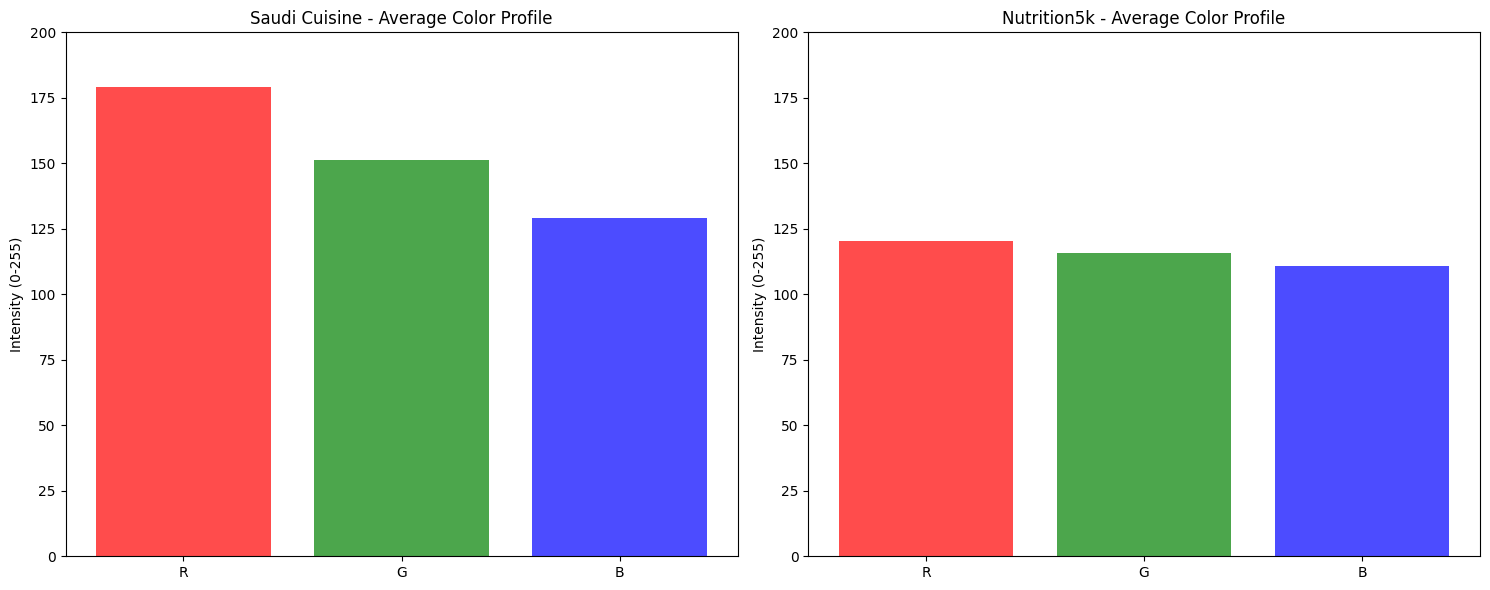


2. Comparing plating patterns...


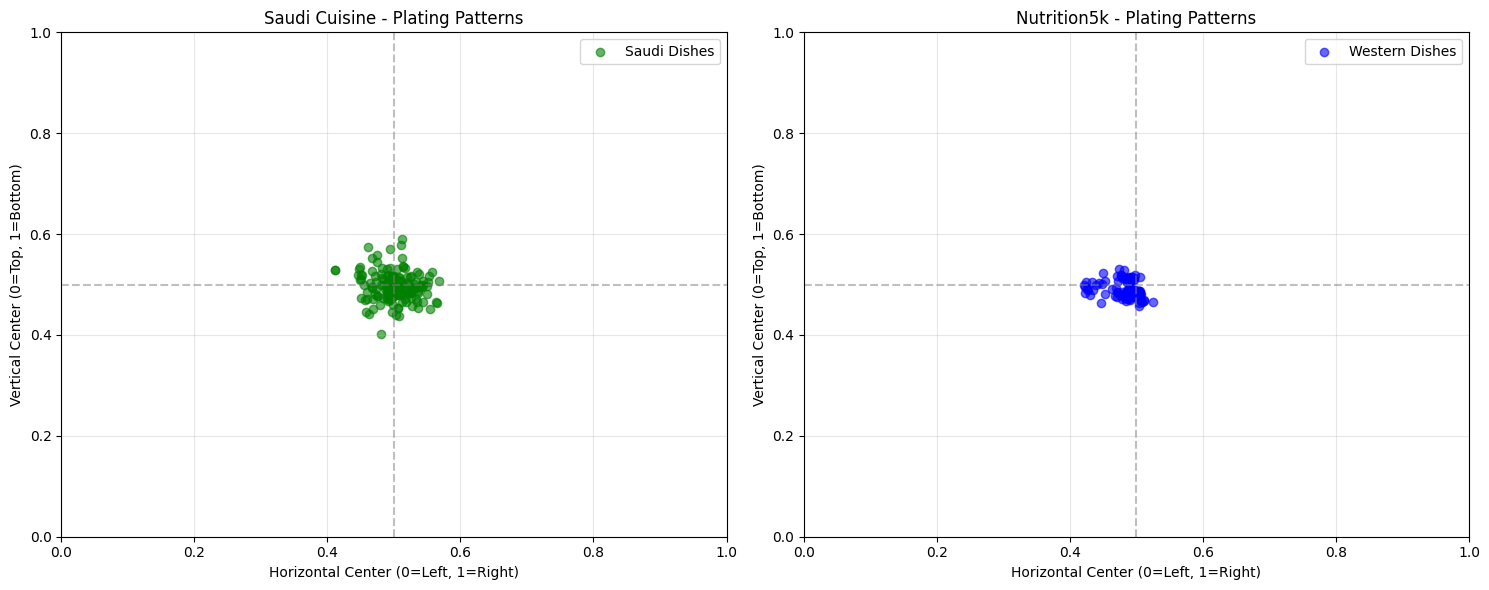


3. Comparing texture complexity...


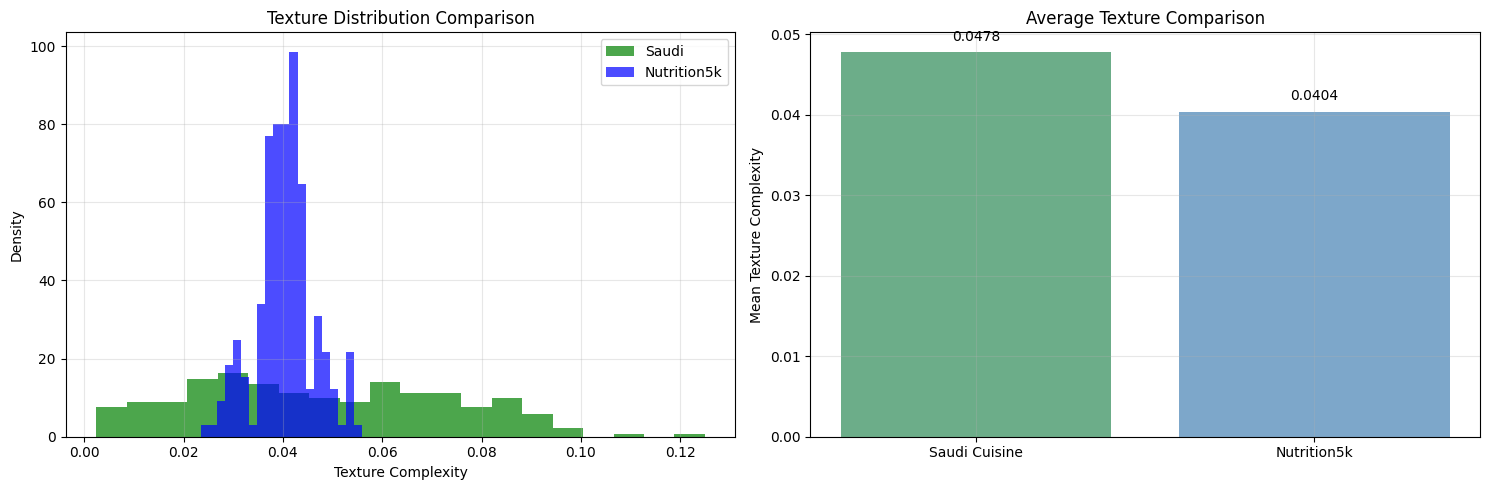


4. Cross-cuisine feature comparison...
Cross-Cuisine Visual Feature Comparison:
              Feature  Saudi_Cuisine  Nutrition5k
0       Red Intensity        179.160      120.165
1     Green Intensity        151.320      115.667
2      Blue Intensity        129.041      110.942
3  Texture Complexity          0.048        0.040
4  Horizontal Balance          0.499        0.490
5    Vertical Balance          0.496        0.487


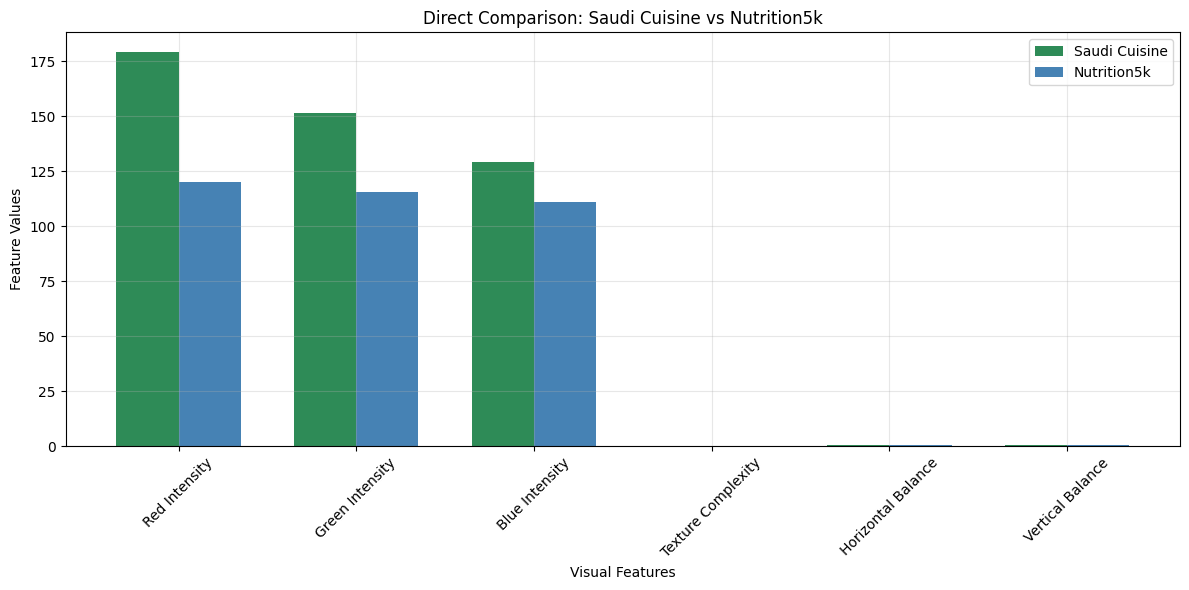


KEY COMPARISON INSIGHTS
🎨 Color Differences:
   Saudi dishes are warmer than Nutrition5k dishes
   Saudi green intensity: 151.3 vs N5K: 115.7
🔍 Texture Differences:
   Saudi dishes are more textured than Nutrition5k dishes
   Texture ratio: 1.18x
📐 Plating Differences:
   Saudi dishes are centered at X: 0.499 vs N5K: 0.490

COMPARISON ANALYSIS COMPLETE!


In [7]:
# --- ADD THESE COMPARISON FUNCTIONS ---

def compare_cuisine_color_profiles(saudi_metrics, n5k_metrics):
    """Compare color signatures between Saudi and Western cuisines"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Saudi cuisine colors
    axes[0].bar(['R', 'G', 'B'],
                [np.mean(saudi_metrics['R']), np.mean(saudi_metrics['G']), np.mean(saudi_metrics['B'])],
                color=['red', 'green', 'blue'], alpha=0.7)
    axes[0].set_title('Saudi Cuisine - Average Color Profile')
    axes[0].set_ylabel('Intensity (0-255)')
    axes[0].set_ylim(0, 200)

    # Nutrition5k colors
    axes[1].bar(['R', 'G', 'B'],
                [np.mean(n5k_metrics['R']), np.mean(n5k_metrics['G']), np.mean(n5k_metrics['B'])],
                color=['red', 'green', 'blue'], alpha=0.7)
    axes[1].set_title('Nutrition5k - Average Color Profile')
    axes[1].set_ylabel('Intensity (0-255)')
    axes[1].set_ylim(0, 200)

    plt.tight_layout()
    plt.show()

def compare_plating_patterns(saudi_com_metrics, n5k_com_metrics):
    """Compare spatial arrangement (plating styles) between cuisines"""

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Saudi cuisine plating
    axes[0].scatter(saudi_com_metrics['CoM_X'], saudi_com_metrics['CoM_Y'],
                   alpha=0.6, color='green', label='Saudi Dishes')
    axes[0].axhline(0.5, color='gray', linestyle='--', alpha=0.5)
    axes[0].axvline(0.5, color='gray', linestyle='--', alpha=0.5)
    axes[0].set_xlim(0, 1)
    axes[0].set_ylim(0, 1)
    axes[0].set_xlabel('Horizontal Center (0=Left, 1=Right)')
    axes[0].set_ylabel('Vertical Center (0=Top, 1=Bottom)')
    axes[0].set_title('Saudi Cuisine - Plating Patterns')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Nutrition5k plating
    axes[1].scatter(n5k_com_metrics['CoM_X'], n5k_com_metrics['CoM_Y'],
                   alpha=0.6, color='blue', label='Western Dishes')
    axes[1].axhline(0.5, color='gray', linestyle='--', alpha=0.5)
    axes[1].axvline(0.5, color='gray', linestyle='--', alpha=0.5)
    axes[1].set_xlim(0, 1)
    axes[1].set_ylim(0, 1)
    axes[1].set_xlabel('Horizontal Center (0=Left, 1=Right)')
    axes[1].set_ylabel('Vertical Center (0=Top, 1=Bottom)')
    axes[1].set_title('Nutrition5k - Plating Patterns')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def cross_cuisine_comparison(saudi_metrics, n5k_metrics):
    """Direct statistical comparison between cuisines"""

    comparison_data = {
        'Feature': ['Red Intensity', 'Green Intensity', 'Blue Intensity',
                   'Texture Complexity', 'Horizontal Balance', 'Vertical Balance'],
        'Saudi_Cuisine': [
            np.mean(saudi_metrics['R']), np.mean(saudi_metrics['G']), np.mean(saudi_metrics['B']),
            np.mean(saudi_metrics['Texture']), np.mean(saudi_metrics['CoM_X']), np.mean(saudi_metrics['CoM_Y'])
        ],
        'Nutrition5k': [
            np.mean(n5k_metrics['R']), np.mean(n5k_metrics['G']), np.mean(n5k_metrics['B']),
            np.mean(n5k_metrics['Texture']), np.mean(n5k_metrics['CoM_X']), np.mean(n5k_metrics['CoM_Y'])
        ]
    }

    comparison_df = pd.DataFrame(comparison_data)
    print("Cross-Cuisine Visual Feature Comparison:")
    print(comparison_df.round(3))

    # Visualization
    fig, ax = plt.subplots(figsize=(12, 6))
    x = np.arange(len(comparison_data['Feature']))
    width = 0.35

    ax.bar(x - width/2, comparison_data['Saudi_Cuisine'], width, label='Saudi Cuisine', color='#2E8B57')
    ax.bar(x + width/2, comparison_data['Nutrition5k'], width, label='Nutrition5k', color='#4682B4')

    ax.set_xlabel('Visual Features')
    ax.set_ylabel('Feature Values')
    ax.set_title('Direct Comparison: Saudi Cuisine vs Nutrition5k')
    ax.set_xticks(x)
    ax.set_xticklabels(comparison_data['Feature'], rotation=45)
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return comparison_df

def compare_texture_complexity(saudi_metrics, n5k_metrics):
    """Compare texture complexity between cuisines"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Texture distribution comparison
    ax1.hist(saudi_metrics['Texture'], bins=20, alpha=0.7, color='green', label='Saudi', density=True)
    ax1.hist(n5k_metrics['Texture'], bins=20, alpha=0.7, color='blue', label='Nutrition5k', density=True)
    ax1.set_xlabel('Texture Complexity')
    ax1.set_ylabel('Density')
    ax1.set_title('Texture Distribution Comparison')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Mean texture comparison
    cuisines = ['Saudi Cuisine', 'Nutrition5k']
    mean_textures = [np.mean(saudi_metrics['Texture']), np.mean(n5k_metrics['Texture'])]
    colors = ['#2E8B57', '#4682B4']

    bars = ax2.bar(cuisines, mean_textures, color=colors, alpha=0.7)
    ax2.set_ylabel('Mean Texture Complexity')
    ax2.set_title('Average Texture Comparison')
    ax2.grid(True, alpha=0.3)

    # Add value labels on bars
    for bar, value in zip(bars, mean_textures):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                f'{value:.4f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

# --- ADD THIS TO YOUR MAIN EXECUTION AFTER BOTH ANALYSES ARE COMPLETE ---

print("\n" + "="*60)
print("STARTING CROSS-CUISINE COMPARISON ANALYSIS")
print("="*60)

# Make sure you have both Saudi and Nutrition5k metrics available
# If you don't have n5k_metrics from previous analysis, you need to load Nutrition5k data first

# Load Nutrition5k metrics (you need to run your Nutrition5k analysis first to get this)
# Here's a quick way to get n5k_metrics if you haven't already:

def load_n5k_metrics():
    """Load Nutrition5k metrics - you need to have run the N5K analysis first"""
    try:
        # If you already ran the Nutrition5k analysis, these variables should exist
        return n5k_samples, all_metrics_n5k
    except NameError:
        print("Nutrition5k analysis not found. Running quick N5K analysis...")
        # Run a quick version of your N5K analysis here
        n5k_samples = load_local_nutrition5k_samples()
        if n5k_samples.size == 0:
            print("Cannot load Nutrition5k data for comparison")
            return None, None
        all_metrics_n5k = calculate_all_per_image_metrics(n5k_samples)
        return n5k_samples, all_metrics_n5k

# Load Nutrition5k data for comparison
n5k_samples, n5k_metrics = load_n5k_metrics()

if n5k_metrics is not None and saudi_samples.size > 0:
    print("✅ Both datasets loaded successfully for comparison!")

    # Now run the comparison visualizations
    print("\n1. Comparing color profiles...")
    compare_cuisine_color_profiles(all_metrics, n5k_metrics)

    print("\n2. Comparing plating patterns...")
    compare_plating_patterns(all_metrics, n5k_metrics)

    print("\n3. Comparing texture complexity...")
    compare_texture_complexity(all_metrics, n5k_metrics)

    print("\n4. Cross-cuisine feature comparison...")
    comparison_results = cross_cuisine_comparison(all_metrics, n5k_metrics)

    # Additional insights
    print("\n" + "="*50)
    print("KEY COMPARISON INSIGHTS")
    print("="*50)

    saudi_red = np.mean(all_metrics['R'])
    n5k_red = np.mean(n5k_metrics['R'])
    saudi_green = np.mean(all_metrics['G'])
    n5k_green = np.mean(n5k_metrics['G'])
    saudi_texture = np.mean(all_metrics['Texture'])
    n5k_texture = np.mean(n5k_metrics['Texture'])

    print(f"🎨 Color Differences:")
    print(f"   Saudi dishes are {'warmer' if saudi_red > n5k_red else 'cooler'} than Nutrition5k dishes")
    print(f"   Saudi green intensity: {saudi_green:.1f} vs N5K: {n5k_green:.1f}")

    print(f"🔍 Texture Differences:")
    print(f"   Saudi dishes are {'more' if saudi_texture > n5k_texture else 'less'} textured than Nutrition5k dishes")
    print(f"   Texture ratio: {saudi_texture/n5k_texture:.2f}x")

    print(f"📐 Plating Differences:")
    saudi_center_x = np.mean(all_metrics['CoM_X'])
    n5k_center_x = np.mean(n5k_metrics['CoM_X'])
    print(f"   Saudi dishes are centered at X: {saudi_center_x:.3f} vs N5K: {n5k_center_x:.3f}")

else:
    print("❌ Cannot perform comparison - one or both datasets missing")
    if saudi_samples.size == 0:
        print("   - Saudi data not loaded")
    if n5k_metrics is None:
        print("   - Nutrition5k data not loaded")

print("\n" + "="*60)
print("COMPARISON ANALYSIS COMPLETE!")
print("="*60)

From the comparative analysis conducted above, we notice some distinction between our data and the general food patterns found in Nutrition5K. The higher mean intensity of the red and green colors in the Saudi dataset can be attributed to the generous and frequent use of spices, such as tumeric and saffron, as well as aromatic herbs in the preparation of many traditional Saudi dishes.

Furthermore, the higher average texture in Saudi food is representative of the traditional plating style of Saudi dishes where components such as rice, meat, and toppings are piled rather than scattered like in Western dishes.

These findings suggest that our model will need to be better attuned to the texture-based traits and wamer color palettes of the Saudi cuisine.  